# Predict Droughts Category using Weather & Soil Data
María Rodríguez & Leila Maritim - First & Second Milestone Machine Learning Project (Winter Semester 2023/24)


## 0. Content
***

**Milestone 1**

1. [Dataset Loading and General Description](#c1)
2. [Definition of Prediction Problem](#c2)
3. [Data Preparation](#c3)
4. [Statistical Analysis](#c4)
    - [Univariate Data Analysis](#c4.1)
    - [Bivariate Data Analysis](#c4.2)
    - [Data Standardization](#c4.3)
5. [Evaluation Protocol](#c5)

**Milestone 2**

6. [Algorithm Selection](#c6)
7. [Definition of functions](#c7)
8. [Proposed Workflow](#c8)
9. [Logistic Regression without Regularization](#c9)
10. [Logistic Regression with Regularization](#c10)
11. [Initial Model](#c11)
12. [Sensitivity to Regularization hyperparameter](#c12)
13. [Hyperparameters Tunning](#c13)
14. [Tunned Model](#c14)
15. [Selection of Explonatory Variables](#c15)
16. [References](#c16)


<div class="alert alert-block alert-info"> <b>NOTE</b> For optimal execution of this notebook, please ensure that you run all cells in sequence. </div>

# Milestone 1

***
## 1. Dataset Loading and General Description <a id='c1'></a>
***

### 1.1 Dataset Source and General Overview <a id='c1.1'></a>

In this project, we are working with two sets of data: meteorological and soil data, which provide information on drought conditions at the county level in the Continental US. The datasets were obtained from [Kaggle](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data/data).

The downloaded datasets were already pre-split into training, validation, and test sets. This splitting was done based on dates to prevent data leakage. This time-based split ensures that the model is trained on past data and evaluated on more recent data, simulating real-world scenarios where predictions need to be made on unseen future data. Here's a breakdown of the date splits:

- Training: ('2000-01-04', '2016-12-27')
- Validation: ('2017-01-03', '2018-12-25')
- Testing: ('2019-01-01', '2020-12-29')

In [160]:
# Importing necessary libraries
import os
import pandas as pd
import warnings
from pandas.errors import SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math

from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### 1.2 Weather Dataset Loading and Description
The meteorological dataset is an open dataset which combines **daily weather observations** as provided by the [NASA POWER Project](https://power.larc.nasa.gov/data-access-viewer/) and **weekly drought scores** provided by [US Drought Monitor](https://droughtmonitor.unl.edu/DmData/DataTables.aspx). The table below provides a general overview of the variables present in the data.

| Variable Name   | Description                                   |
| -----------     | --------------------------------------------- |
| FIPS            | US county codes                               |
| date            | Date object                                   |
| PRECTOT         | Precipitation (mm day-1)                      |
| PS              | Surface pressure (Kpa)                        |
| QV2M            | Specific humidity at 2 Meters (g/kg)          |
| T2M             | Temperature at 2 Meters (C)                   |
| T2MDEW          | Dew/Frost point at 2 Meters (C)               |
| T2MWET          | Wet bulb temperature at 2 Meters (C)          |
| T2M_MAX         | Maximum temperatures at 2 Meters (C)          |
| T2M_MIN         | Minimum temperature at 2 Meters (C)           |
| T2M_RANGE       | Temperature range at 2 Meters (C)             |
| TS              | Earth skin temperature (C)                    |
| WS10M           | Wind speed at 10 Meters (m/s)                 |
| WS10M_MAX       | Maximum Wind speed at 10 Meters (m/s)         |
| WS10M_MIN       | Minimum Wind speed at 10 Meters (m/s)         |
| WS10M_RANGE     | Wind speed range at 10 Meters (m/s)           |
| WS50M           | Wind speed at 50 Meters (m/s)                 |
| WS50M_MAX       | Maximum Wind speed at 50 Meters (m/s)         |
| WS50M_MIN       | Minimum Wind speed at 50 Meters (m/s)         |
| WS50M_RANGE     | Wind speed range at 50 Meters (m/s)           |
| score           | Drought score                                 |

In [161]:
# Weather data: Load training, validation and testing datasets
# Define the base data directory and subdirectories
data_dir = 'data'
subdirs = ['train_timeseries', 'validation_timeseries', 'test_timeseries']

# Load the datasets
datasets = {}
for subdir in subdirs:
    file_name = f'{subdir}.csv'
    file_path = os.path.join(data_dir, subdir, file_name)
    datasets[subdir] = pd.read_csv(file_path)

# Access the datasets using their keys
train_w_df = datasets['train_timeseries']
val_w_df = datasets['validation_timeseries']
test_w_df = datasets['test_timeseries']

The initial training dataset comprises 21 columns, encompassing both weather and the drought score variable. The data types within this dataset include float64 for 19 columns, int64 for 1 column (FIPS code), and object (str) for 1 column (date). In terms of data volume, this dataset is quite extensive, with a total of 19,300,680 rows, except for the score variable, which has 2,756,796 rows. The dataset consumes approximately 3.0 gigabytes (GB) of storage space.

In [162]:
train_w_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [163]:
# Training Dataset
train_w_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   fips         19300680 non-null  int64  
 1   date         19300680 non-null  object 
 2   PRECTOT      19300680 non-null  float64
 3   PS           19300680 non-null  float64
 4   QV2M         19300680 non-null  float64
 5   T2M          19300680 non-null  float64
 6   T2MDEW       19300680 non-null  float64
 7   T2MWET       19300680 non-null  float64
 8   T2M_MAX      19300680 non-null  float64
 9   T2M_MIN      19300680 non-null  float64
 10  T2M_RANGE    19300680 non-null  float64
 11  TS           19300680 non-null  float64
 12  WS10M        19300680 non-null  float64
 13  WS10M_MAX    19300680 non-null  float64
 14  WS10M_MIN    19300680 non-null  float64
 15  WS10M_RANGE  19300680 non-null  float64
 16  WS50M        19300680 non-null  float64
 17  WS50M_MAX    19300680 non

Similar to the training data, the number of columns and data types remain consistent in this dataset. There are 2,268,840 rows in total, with the exception of the score variable, which contains 323,232 rows. The dataset retains the same structure as the training data, with 21 columns featuring data types such as float64 (19 columns), int64 (1 column for FIPS code), and object (1 column for date) occupying  363.5 MB of storage.

In [164]:
# Validation Dataset
val_w_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268840 entries, 0 to 2268839
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fips         2268840 non-null  int64  
 1   date         2268840 non-null  object 
 2   PRECTOT      2268840 non-null  float64
 3   PS           2268840 non-null  float64
 4   QV2M         2268840 non-null  float64
 5   T2M          2268840 non-null  float64
 6   T2MDEW       2268840 non-null  float64
 7   T2MWET       2268840 non-null  float64
 8   T2M_MAX      2268840 non-null  float64
 9   T2M_MIN      2268840 non-null  float64
 10  T2M_RANGE    2268840 non-null  float64
 11  TS           2268840 non-null  float64
 12  WS10M        2268840 non-null  float64
 13  WS10M_MAX    2268840 non-null  float64
 14  WS10M_MIN    2268840 non-null  float64
 15  WS10M_RANGE  2268840 non-null  float64
 16  WS50M        2268840 non-null  float64
 17  WS50M_MAX    2268840 non-null  float64
 18  WS

The testing data is the smallest among the datasets, consuming approximately 364.0+ megabytes (MB) of storage space. It consists of 2,271,948 rows for all variables, with the exception of the score variable, which contains 326,340 rows. The testing dataset shares the same structure as the training and validation datasets, maintaining 21 columns with data types including float64 (19 columns), int64 (1 column for FIPS code), and object (1 column for date).

In [165]:
# Testing Dataset
test_w_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fips         2271948 non-null  int64  
 1   date         2271948 non-null  object 
 2   PRECTOT      2271948 non-null  float64
 3   PS           2271948 non-null  float64
 4   QV2M         2271948 non-null  float64
 5   T2M          2271948 non-null  float64
 6   T2MDEW       2271948 non-null  float64
 7   T2MWET       2271948 non-null  float64
 8   T2M_MAX      2271948 non-null  float64
 9   T2M_MIN      2271948 non-null  float64
 10  T2M_RANGE    2271948 non-null  float64
 11  TS           2271948 non-null  float64
 12  WS10M        2271948 non-null  float64
 13  WS10M_MAX    2271948 non-null  float64
 14  WS10M_MIN    2271948 non-null  float64
 15  WS10M_RANGE  2271948 non-null  float64
 16  WS50M        2271948 non-null  float64
 17  WS50M_MAX    2271948 non-null  float64
 18  WS

### 1.3 Soil Dataset Loading and Description <a id='c1.3'></a>

The soil data is sourced from [The Harmonized World Soil Database (HWSD)](https://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/harmonized-world-soil-database-v12/en/), which is a comprehensive global database providing detailed information on soil properties and classifications. Unlike the weather data, this dataset is static and location-based, meaning it doesn't have temporal resolution.

The soil dataset encompasses a wide range of properties and classifications, including:

| Properties/Classifications | Description and Related Variables                                | Data type         |
| -------------------------- | ------------------------------------------- |-------------------|
| Fips                       | County codes                                | int               |
| Lon                        | Longitude                                   | float             |
| Lat                        | Latitude                                    | float             |  
| Elevation                  | Median elevation (meters)                   | int               |
| Slope                      | Slope classes                               | float  |
|                            | - slope1: 0% ≤ slope ≤ 0.5%                 | float  |
|                            | - slope2: 0.5% ≤ slope ≤ 2%                 | float  |
|                            | - slope3: 2% ≤ slope ≤ 5%                 |   float  |
|                            | - slope4: 5% ≤ slope ≤ 10%                |   float  |
|                            | - slope5: 10% ≤ slope ≤ 15%               |   float  |
|                            | - slope6: 15% ≤ slope ≤ 30%               |   float  |
|                            | - slope7: 30% ≤ slope ≤ 45%               |   float  |
|                            | - slope8: Slope > 45%                      |  float  |
| Aspect                     | Aspect classes (degrees)                    | float  |
|                            | - aspectN: North (0˚ < aspect ≤ 45˚)        | float  |
|                            | - aspectE: East (45˚ < aspect ≤ 135˚)       | float  |
|                            | - aspectW: South (135˚ < aspect ≤ 225˚)     | float  |
|                            | - aspectS: West (225˚ < aspect ≤ 315˚)     |  float  | 
| Landcover                  | Major land cover/land use categories        | float  |
|                            | - WAT_LAND: Mapped water bodies             | float  |
|                            | - NVG_LAND: Barren/very sparsely vegetated land | float |
|                            | - URB_LAND: Built-up land                    | float |
|                            | - GRS_LAND: Grass/scrub/woodland            | float |
|                            | - FOR_LAND: Forest land                      | float |
|                            | - CULTRF_LAND: Rain-fed cultivated land     | float  |
|                            | - CULTIR_LAND: Irrigated cultivated land    | float |
|                            | - CULT_LAND: Total cultivated land          | float  |
| Soil Quality               | Soil Qualities for Crop Production           | float |
|                            | - SQ1: Nutrient availability                 | int  |
|                            | - SQ2: Nutrient retention capacity           | int |
|                            | - SQ3: Rooting condition                     | int  |
|                            | - SQ4: Oxygen availability                   | int |
|                            | - SQ5: Excess salts                          | int  |
|                            | - SQ6: Toxicity                            | int |
|                            | - SQ7: Workability                           | int  |

The dataset is relatively substantial in size, occupying approximately 777.4 kilobytes (KB) of storage space. 

In [166]:
# Load Soil data
soil_df=pd.read_csv('data/soil_data.csv')

In [167]:
soil_df.head()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


In [168]:
# Soil data
soil_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

***
## 2. Definition of Prediction Problem <a id='c2'></a>
***
The target variable, 'score,' represents a continuous numerical value that indicates the level of drought. Consequently, we have the flexibility to define either a Regression or Classification task based on the label's data type. For this project, we opted for a classification approach, with the aim of predicting drought categories based on Weather and Soil data. These categories align with the classifications established by the [US Drought Monitor](https://droughtmonitor.unl.edu/CurrentMap.aspx) and include No Drought and five additional categories as outlined below:

![Drought Categories](img/D_categories.png)

The decision to pursue a classification task instead of regression is motivated by our curiosity to explore the application of Logistic Regression in a multiclass context and to address the challenges posed by imbalanced datasets, which are frequently encountered in real-world scenarios.


***
## 3. Data Preparation <a id='c3'></a>
***

### 3.1 Null Values Handling
In our dataset, weather data is collected on a daily basis, providing detailed information for each day. However, the drought score data is available only on a weekly basis, resulting in gaps where score values are not present for daily observations.

To address this temporal resolution discrepancy, we have opted to handle null values by removing them from the dataset. This decision ensures that our analysis focuses on the days for which drought score information is available, providing us with a consistent and complete dataset.

While this approach results in a reduced dataset, it allows us to maintain data integrity and work with a sufficient number of data points to effectively train our predictive model.

In [169]:
weather_datasets = [train_w_df, val_w_df, test_w_df]
weather_dataset_names = ['Weather Dataset - Training', 'Weather Dataset - Validation', 'Weather Dataset - Testing']

In [170]:
# Null Values
for dataset in weather_datasets:
    dataset.dropna(subset=['score'], inplace=True)
train_w_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2756796 entries, 3 to 19300675
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fips         2756796 non-null  int64  
 1   date         2756796 non-null  object 
 2   PRECTOT      2756796 non-null  float64
 3   PS           2756796 non-null  float64
 4   QV2M         2756796 non-null  float64
 5   T2M          2756796 non-null  float64
 6   T2MDEW       2756796 non-null  float64
 7   T2MWET       2756796 non-null  float64
 8   T2M_MAX      2756796 non-null  float64
 9   T2M_MIN      2756796 non-null  float64
 10  T2M_RANGE    2756796 non-null  float64
 11  TS           2756796 non-null  float64
 12  WS10M        2756796 non-null  float64
 13  WS10M_MAX    2756796 non-null  float64
 14  WS10M_MIN    2756796 non-null  float64
 15  WS10M_RANGE  2756796 non-null  float64
 16  WS50M        2756796 non-null  float64
 17  WS50M_MAX    2756796 non-null  float64
 18  W

### 3.2 Merge Weather and Soil Datasets
Both the weather data and the soil data sets indeed were confirmed to include a column labeled "FIPS." FIPS codes, an acronym for Federal Information Processing System codes, serve as numerical identifiers that provide unique representation for states and counties within the United States. In this study, the FIPS codes are employed at the county level.

More information [here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

In [171]:
# Verify that there is soil data associated for all the weather observations
for dataset, dataset_name in zip(weather_datasets, weather_dataset_names):
    all_values_exist = dataset['fips'].isin(soil_df['fips']).all()
    if all_values_exist:
        print(f"All fips values in {dataset_name} exist in Soil Dataset.")
    else:
        print(f"Not all values in {dataset_name}'s fips column exist in Soil Dataset.")

All fips values in Weather Dataset - Training exist in Soil Dataset.
All fips values in Weather Dataset - Validation exist in Soil Dataset.
All fips values in Weather Dataset - Testing exist in Soil Dataset.


In [172]:
# Merge Weather and Soil Data
for i, dataset in enumerate(weather_datasets):
    weather_datasets[i] = pd.merge(dataset, soil_df, on="fips", how="left")
train_m_df, val_m_df, test_m_df = weather_datasets

In [173]:
train_m_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2


### 3.3 Concatenate Training and Testing datasets
In preparation for upcoming milestones, where model tuning will involve cross-validation using Scikit-Learn, we combine the training and validation datasets. This is done because Scikit-Learn will take care of automatically defining and splitting the validation dataset during the cross-validation process.

In [174]:
# Concatenate the validation data to the training data
train_m_df = pd.concat([train_m_df, val_m_df], axis=0)

# Reset the index of the merged DataFrame
train_m_df.reset_index(drop=True, inplace=True)

In [175]:
train_m_df.shape

(3080028, 52)

### 3.4 Verify the presence of duplicate observations
No duplicates were observed in this dataset.

In [176]:
datasets_names = ['Training Dataset', 'Testing Dataset']

In [177]:
# Duplicates identification
merged_datasets = [train_m_df, test_m_df]
for dataset, dataset_name in zip(merged_datasets, datasets_names):
    duplicates = dataset[dataset.duplicated()]
    if duplicates.empty:
        print(f"{dataset_name} dataset has no duplicates")
    else:
        print(f"{dataset_name} dataset has duplicates")

Training Dataset dataset has no duplicates
Testing Dataset dataset has no duplicates


### 3.5 Geographical Limitation of Datasets to the Continental West Region of the United States

To address the challenges associated with a large dataset, which can lead to extended training times and high resource consumption for future model trainings, we decided to narrow our focus to the Mountain West States of the United States. This selection was made based on the publication of Bolinger (2019) in the National Integrated Drought Information System (Drought.gov), which categorizes this region as Drought-Prone. The states included in this geographical limitation are Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, and Wyoming. To ensure inclusion, the FIPS code for the counties in these states should begin with the following values:

| State       | FIPS Code |
|-------------|-----------|
| Arizona     | 04        |
| Colorado    | 08        |
| Idaho       | 16        |
| Montana     | 30        |
| Nevada      | 32        |
| New Mexico  | 35        |
| Utah        | 49        |
| Wyoming     | 56        |

As it can be checked on the [documentation](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697).

In [178]:
# Loop through each DataFrame and apply the filtering
merged_datasets = [train_m_df, test_m_df]
for i, df in enumerate(merged_datasets):
    merged_datasets[i] = df[(df['fips'].astype(str).str.len() == 4) & (df['fips'].astype(str).str.startswith(('4','8'))) | (df['fips'].astype(str).str.startswith(('16', '30', '32', '35', '49', '56')))]
train_m_df, test_m_df = merged_datasets

print('Training dataset size:', train_m_df.shape)
print('Testing dataset size:', test_m_df.shape)

Training dataset size: (277480, 52)
Testing dataset size: (29400, 52)


In [179]:
train_m_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
59429,4001,2000-01-04,0.01,80.87,1.36,-3.73,-14.89,-14.33,4.02,-10.30,...,0.0,0.0,0.0,1,1,1,1,2,1,1
59430,4001,2000-01-11,0.00,80.29,2.13,1.27,-9.98,-9.77,10.42,-3.33,...,0.0,0.0,0.0,1,1,1,1,2,1,1
59431,4001,2000-01-18,0.13,80.78,4.18,7.66,-1.69,-1.66,16.18,1.94,...,0.0,0.0,0.0,1,1,1,1,2,1,1
59432,4001,2000-01-25,2.04,80.31,4.32,6.29,-1.36,-1.33,14.77,-0.11,...,0.0,0.0,0.0,1,1,1,1,2,1,1
59433,4001,2000-02-01,0.15,80.72,2.58,-1.00,-7.69,-7.60,7.46,-6.24,...,0.0,0.0,0.0,1,1,1,1,2,1,1


### 3.6 Reformat of specific explonatory variables and target variable <a id='c3.6'></a>
Our criteria for classifying variables as either categorical or numerical are primarily based on data type. To make the data suitable for modeling, several transformations were applied:

1. **Date Transformation**: The date variable was converted from an object format (str) to two new variables representing the Day-Of-Year (doy) and the year. This transformation allows the model to effectively use temporal information.

2. **Elevation**: The elevation variable was converted to a float type, placing it in the numerical category. This change ensures that elevation can be treated as a continuous variable for modeling purposes.

3. **Drought Score**: The drought score, initially quantitative with a float data type, was converted to qualitative with an integer data type, reducing it to six distinct categories, as specified in the data documentation. The categories are:
    * 0: No Drought
    * 1: D0 - Abnormally Dry
    * 2: D1 - Moderate Drought
    * 3: D2 - Severe Drought
    * 4: D3 - Extreme Drought
    * 5: D4 - Exceptional Drought

In [180]:
merged_datasets = [train_m_df, test_m_df]
for dataset in merged_datasets:
    # Split the date column into DOY and year
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset['doy'] = dataset['date'].dt.dayofyear
    dataset['year'] = dataset['date'].dt.year
    
    # Drop the original 'date' column if you no longer need it
    dataset.drop(columns=['date'], inplace=True)
    
    # Reformat elevation
    dataset['elevation'] = dataset['elevation'].astype('float64')
    
    # Round the 'score' column to the nearest integer in the modified dataset
    dataset['score'] = dataset['score'].round().astype('int64') 
train_m_df, test_m_df = merged_datasets

In [181]:
train_m_df.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,doy,year
59429,4001,0.01,80.87,1.36,-3.73,-14.89,-14.33,4.02,-10.30,14.31,...,0.0,1,1,1,1,2,1,1,4,2000
59430,4001,0.00,80.29,2.13,1.27,-9.98,-9.77,10.42,-3.33,13.75,...,0.0,1,1,1,1,2,1,1,11,2000
59431,4001,0.13,80.78,4.18,7.66,-1.69,-1.66,16.18,1.94,14.24,...,0.0,1,1,1,1,2,1,1,18,2000
59432,4001,2.04,80.31,4.32,6.29,-1.36,-1.33,14.77,-0.11,14.88,...,0.0,1,1,1,1,2,1,1,25,2000
59433,4001,0.15,80.72,2.58,-1.00,-7.69,-7.60,7.46,-6.24,13.70,...,0.0,1,1,1,1,2,1,1,32,2000


### 3.7 Time Limitation of Training Dataset

To further streamline the model training and tuning phase and facilitate its management, we opted to aslo trim the training data to cover only the years from 2014 to 2018.

In [182]:
train_m_df = train_m_df[train_m_df['year'] >= 2014]
print('Training dataset size:', train_m_df.shape)

Training dataset size: (72800, 53)


### 3.8 Nominal Categorical Data encoding <a id='c3.7'></a>
In our dataset, we have identified **nominal** categorical variables that describe important soil qualities (SQ) influencing crop production. These variables include Nutrient availability (SQ1), Nutrient retention capacity (SQ2), Rooting conditions (SQ3), Oxygen availability to roots (SQ4), Excess salts (SQ5), Toxicity (SQ6), and Workability (SQ7). Each of these variables has assigned values ranging from 1 to 7, representing varying levels of soil quality limitations:

* 1: No or slight limitations
* 2: Moderate limitations
* 3: Severe limitations
* 4: Very severe limitations
* 5: Mainly non-soil
* 6: Permafrost area
* 7: Water bodies

It is important to note that these values are qualitative and not quantitative. Then, to effectively incorporate this categorical information into our analysis, we employ a technique known as "dummy encoding". This encoding process is essential for converting nominal categorical data into a numerical format that can be used as input for machine learning algorithms.

#### 3.8.1 Dummy Encoding
In dummy encoding, each class within a categorical variable is transformed into a set of binary or "dummy" variables. These binary variables represent the presence or absence of each category. Typically, binary values are used, where 0 indicates the absence of a category, and 1 indicates the presence of a category.

For example, consider the 'SQ1' feature, which may have multiple classes such as [1, 2, 3, 4, 6, 7]. To perform dummy encoding for 'SQ1,' a set of new variables like 'SQ1_1', 'SQ1_2', 'SQ1_3', 'SQ1_4', 'SQ1_6' and 'SQ1_7' is generated. Each of these new variables corresponds to one of the unique classes found within 'SQ1' and indicates whether that specific class is present (1) or absent (0) for each observation.

It's fundamental to consider that one class is typically dropped during dummy encoding. This is known as the reference category, and it can be inferred from the other categories. Dropping one category helps prevent multicollinearity, where one category's presence can be perfectly predicted from the absence of the others, which could lead to issues in model training and interpretation.

* **Pros**:

    Soil quality nominal categorical variable, meaning that it lacks any inherent order or ranking among its categories. When we encode this variable using techniques such as dummy encoding, we assist the machine learning model in treating the categories as distinct and unrelated. This prevents the model from assuming any inherent order or hierarchy among the soil quality categories, ensuring that it makes predictions based solely on the presence or absence of specific soil quality attributes.

* **Cons**:

    One drawback of this encoding scheme is that it introduces sparsity in the dataset. This means that several columns will contain 0s, and only a few of them will have 1s. In other words, it creates multiple dummy features in the dataset without necessarily adding substantial new information (Saxena, 2023).

In [183]:
# CATEGORICAL DATA ENCODING
# Define the nominal categorical columns
SQ_vars = ['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']
merged_datasets = [train_m_df, test_m_df]

for i, dataset in enumerate(merged_datasets):  
    # Convert categorical columns to 'category' type and create dummies
    df_dummies = pd.get_dummies(dataset[SQ_vars].astype('category'), drop_first=True)    
    # Drop the original categorical columns from the DataFrame
    merged_datasets[i] = dataset.drop(SQ_vars, axis=1)
    # Concatenate the DataFrame with the dummy variables horizontally
    merged_datasets[i] = pd.concat([merged_datasets[i], df_dummies], axis=1)    
train_df, test_df = merged_datasets

In [184]:
train_df.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,SQ5_7,SQ6_2,SQ6_3,SQ6_6,SQ6_7,SQ7_2,SQ7_3,SQ7_4,SQ7_6,SQ7_7
60160,4001,0.00,80.44,1.91,0.88,-11.27,-10.95,7.60,-3.34,10.94,...,0,0,0,0,0,0,0,0,0,0
60161,4001,0.00,81.12,2.52,0.06,-7.89,-7.78,8.62,-4.58,13.19,...,0,0,0,0,0,0,0,0,0,0
60162,4001,0.00,80.93,1.89,3.82,-11.27,-10.87,13.21,-2.89,16.10,...,0,0,0,0,0,0,0,0,0,0
60163,4001,0.00,80.38,1.85,0.55,-11.68,-11.28,8.69,-3.32,12.01,...,0,0,0,0,0,0,0,0,0,0
60164,4001,0.34,79.67,2.40,-2.01,-8.80,-8.67,2.93,-5.51,8.44,...,0,0,0,0,0,0,0,0,0,0


### 3.9 Summary of Variables in Training Dataset after cleaning & filtering process
The preprocessed Training dataset now exhibits the following structure:

* **Total Entries**: 
    72,800 entries

* **Variables data types**: There are 76 variables in total, consisting of:

  * float64: 42 variables
  * int64: 4 variables
  * uint8: 30 variables
  
* **Numerical variables**: including of all the variables with a data type of float64 and doy

* **Categorical variables**: fips, year as well as the Soil Quality (SQ) related Variables.

* **Target Categorical variable**: score.

* **Storage Space**: The dataset consumes approximately 28.2 MB of storage space.

This preprocessed dataset is now ready for further statistical analysis.

In [185]:
# Ammount of variables after preprocessing
train_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72800 entries, 60160 to 3080027
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           72800 non-null  int64  
 1   PRECTOT        72800 non-null  float64
 2   PS             72800 non-null  float64
 3   QV2M           72800 non-null  float64
 4   T2M            72800 non-null  float64
 5   T2MDEW         72800 non-null  float64
 6   T2MWET         72800 non-null  float64
 7   T2M_MAX        72800 non-null  float64
 8   T2M_MIN        72800 non-null  float64
 9   T2M_RANGE      72800 non-null  float64
 10  TS             72800 non-null  float64
 11  WS10M          72800 non-null  float64
 12  WS10M_MAX      72800 non-null  float64
 13  WS10M_MIN      72800 non-null  float64
 14  WS10M_RANGE    72800 non-null  float64
 15  WS50M          72800 non-null  float64
 16  WS50M_MAX      72800 non-null  float64
 17  WS50M_MIN      72800 non-null  float64
 18  

In [186]:
# Final Percentage of the training-test-split
total_rows = len(train_df)+ len(test_df)

train_percentage = (len(train_df) / total_rows) * 100
test_percentage = (len(test_df) / total_rows) * 100

print(f"Training dataset percentage: {train_percentage:.2f}%")
print(f"Testing dataset percentage {test_percentage:.2f}%")

Training dataset percentage: 71.23%
Testing dataset percentage 28.77%


***
## 4. Statistical Analysis <a id='c4'></a>
***
To begin with, we partitioned the explanatory variables from the labels. Furthermore, we excluded the 'fips' and 'CULT_LAND' variables from the pool of explanatory variables. This decision was made because 'fips' serves as a unique identifier for U.S. counties, and the geographical information it contains can also be derived from the 'lat' and 'long' variables. As for 'CULT_LAND', it was omitted since it  essentially duplicates information found in the 'CULTRF_LAND' and 'CULTIR_LAND' variables, as it represents the sum of both.

In [187]:
# List of columns to exclude in exploratory variables
exclude_vars = ['fips', 'CULT_LAND']
train_df = train_df.drop(columns=exclude_vars)
test_df = test_df.drop(columns=exclude_vars)


# Division Explanatory Variables and Target
X_train = train_df.drop(columns='score')
y_train = train_df['score']
X_test = test_df.drop(columns='score')
y_test = test_df['score']

### 4.1 Univariate Data Analysis <a id='c4.1'></a>
The following Univariate Data Analysis was conducted not only on the Training dataset but also on the Testing dataset to ensure that they exhibit the same distribution while remaining independent of each other.

#### 4.1.1 Numerical Exploratory Variables
In the subsequent tables, we specifically provide descriptive statistics for the numerical explanatory variables within the Training and Testing datasets.


When comparing the tables, we observe that the statistical values for all variables exhibit remarkable similarity among them. Additionally, the tables highlight variations in the scales of the explanatory variables, a distinction of particular significance due to our intention to utilize Machine Learning Algorithms that rely on Gradient Descent. In the [4.3 Data Standardization](#c4.3) Section, we elaborate on the process of standardizing these variables using their respective mean and standard deviation. This standardization is crucial to ensure the convergence of the Gradient Descent algorithm.

In [188]:
# Training Set Descriptive Statistics
pd.set_option('display.max_columns', None)
X_train_num = X_train.select_dtypes(include=['float64','int64']).drop(columns=['year'])
X_train_num.describe()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,doy
count,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,7.280000e+04,72800.000000,72800.000000
mean,1.268001,83.132941,4.831562,8.800002,-1.153993,-1.055612,15.610860,2.685154,12.925747,8.788249,3.522531,5.521891,1.631602,3.890302,5.175652,7.720431,2.549548,5.170903,40.995281,-109.616095,1643.110714,0.032175,0.219766,0.245631,0.156436,0.082300,0.142907,0.072792,0.047991,0.183482,0.205575,0.167419,0.191583,0.251942,0.488473,10.915195,0.913064,48.582838,30.778296,3.165380e+00,5.156754,183.100000
std,2.878538,5.522599,2.665541,10.860140,7.667717,7.524379,11.934028,9.821310,3.985000,11.625706,1.706715,2.517925,1.254444,1.942313,2.345869,2.989904,2.050696,2.237181,4.473136,4.324527,606.838052,0.047859,0.226273,0.173155,0.118894,0.072762,0.153255,0.103373,0.101375,0.101314,0.113695,0.103507,0.121730,0.267605,4.064332,14.619988,6.477796,29.091628,34.352125,6.593610e+00,11.619897,105.075409
min,0.000000,66.930000,0.330000,-27.480000,-27.960000,-27.620000,-21.420000,-34.500000,0.160000,-31.430000,0.400000,0.890000,0.000000,0.330000,0.560000,1.200000,0.000000,0.540000,31.525904,-119.743442,102.000000,0.000000,0.000400,0.002600,0.000000,0.000000,0.000000,0.000000,0.000000,0.001600,0.004500,0.000900,0.002000,0.000400,0.000000,0.000000,0.000000,0.982222,0.000000,0.000000e+00,0.000000,2.000000
25%,0.000000,79.540000,2.820000,0.577500,-6.590000,-6.450000,6.130000,-3.930000,9.930000,0.030000,2.280000,3.630000,0.680000,2.450000,3.440000,5.500000,0.950000,3.510000,37.883809,-112.806798,1257.000000,0.001000,0.017575,0.082175,0.050375,0.014275,0.001775,0.000000,0.000000,0.102775,0.114825,0.079300,0.099575,0.018700,0.000000,0.240995,0.000000,19.268528,0.000000,0.000000e+00,0.000000,92.500000
50%,0.130000,83.190000,4.110000,8.740000,-1.565000,-1.540000,16.200000,2.310000,13.130000,8.700000,3.150000,5.080000,1.360000,3.530000,4.730000,7.360000,2.010000,4.820000,40.564889,-109.317037,1575.000000,0.010450,0.131000,0.241950,0.139500,0.070150,0.080300,0.008200,0.000100,0.177600,0.203650,0.157950,0.175500,0.144350,0.000000,6.261527,0.030250,49.701103,11.835799,5.960464e-08,0.194582,183.000000
75%,1.140000,86.730000,6.330000,17.660000,4.460000,4.450000,25.250000,10.420000,15.990000,18.090000,4.370000,6.900000,2.250000,4.940000,6.450000,9.450000,3.600000,6.480000,44.634833,-105.748387,1988.750000,0.047025,0.366025,0.383950,0.240900,0.136025,0.252450,0.116975,0.054450,0.254375,0.280550,0.241250,0.266725,0.411025,0.000000,13.978830,0.152775,74.221794,67.562935,2.948661e+00,3.401689,273.500000
max,47.170000,99.980000,16.670000,40.110000,21.110000,21.030000,50.030000,32.140000,26.390000,42.210000,14.580000,20.270000,12.530000,15.810000,18.120000,26.110000,15.860000,18.570000,48.794429,-102.345105,3561.000000,0.303900,0.759900,0.644000,0.515200,0.285800,0.586200,0.435500,0.628800,0.475000,0.738500,0.511200,0.657800,0.988100,52.000000,77.399567,88.963181,99.976303,91.044609,5.152046e+01,83.141327,364.000000


In [189]:
# Test Set Descriptive Statistics
X_test_num = X_test.select_dtypes(include=['float64','int64']).drop(columns=['year'])
X_test_num.describe()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,doy
count,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.00000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.00000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,2.940000e+04,29400.000000,29400.000000
mean,1.164837,83.086896,4.548475,8.164611,-2.070112,-1.767630,15.11384,1.949315,13.164505,8.127577,3.601292,5.650879,1.644103,4.006800,5.276931,7.848723,2.58993,5.258831,40.995281,-109.616095,1643.110714,0.032175,0.219766,0.245631,0.156436,0.082300,0.142907,0.072793,0.047991,0.183482,0.205575,0.167419,0.191583,0.251942,0.488473,10.915195,0.913064,48.582838,30.778296,3.165380e+00,5.156754,184.238095
std,2.758895,5.524763,2.526473,11.415269,7.937614,7.491139,12.53100,10.360443,3.958920,12.165678,1.685777,2.514769,1.224497,2.006486,2.314535,2.941846,2.04126,2.282176,4.473181,4.324571,606.844205,0.047860,0.226275,0.173157,0.118895,0.072763,0.153257,0.103374,0.101376,0.101315,0.113696,0.103508,0.121731,0.267608,4.064374,14.620136,6.477862,29.091923,34.352473,6.593677e+00,11.620015,106.092468
min,0.000000,66.930000,0.320000,-24.830000,-30.560000,-25.860000,-22.51000,-29.070000,0.480000,-26.530000,0.460000,1.000000,0.010000,0.390000,0.700000,1.370000,0.01000,0.760000,31.525904,-119.743442,102.000000,0.000000,0.000400,0.002600,0.000000,0.000000,0.000000,0.000000,0.000000,0.001600,0.004500,0.000900,0.002000,0.000400,0.000000,0.000000,0.000000,0.982222,0.000000,0.000000e+00,0.000000,1.000000
25%,0.000000,79.490000,2.660000,-0.630000,-7.480000,-6.860000,4.84000,-5.070000,10.210000,-1.240000,2.350000,3.730000,0.700000,2.530000,3.520000,5.640000,0.98000,3.580000,37.883809,-112.806798,1257.000000,0.001000,0.017575,0.082175,0.050375,0.014275,0.001775,0.000000,0.000000,0.102775,0.114825,0.079300,0.099575,0.018700,0.000000,0.240995,0.000000,19.268528,0.000000,0.000000e+00,0.000000,92.000000
50%,0.090000,83.150000,3.930000,7.965000,-2.220000,-2.110000,15.44000,1.565000,13.430000,7.960000,3.240000,5.180000,1.390000,3.610000,4.850000,7.510000,2.08000,4.890000,40.564889,-109.317037,1575.000000,0.010450,0.131000,0.241950,0.139500,0.070150,0.080300,0.008200,0.000100,0.177600,0.203650,0.157950,0.175500,0.144350,0.000000,6.261527,0.030250,49.701103,11.835799,5.960464e-08,0.194582,183.000000
75%,0.950000,86.690000,6.000000,17.520000,3.712500,3.600000,25.59000,9.980000,16.250000,17.870000,4.520000,7.110000,2.290000,5.080000,6.620000,9.630000,3.69000,6.570000,44.634833,-105.748387,1988.750000,0.047025,0.366025,0.383950,0.240900,0.136025,0.252450,0.116975,0.054450,0.254375,0.280550,0.241250,0.266725,0.411025,0.000000,13.978830,0.152775,74.221794,67.562935,2.948661e+00,3.401689,274.000000
max,41.910000,99.640000,15.990000,39.110000,20.160000,20.010000,46.60000,31.760000,24.210000,42.400000,15.280000,20.420000,10.990000,15.130000,18.540000,24.720000,14.19000,18.140000,48.794429,-102.345105,3561.000000,0.303900,0.759900,0.644000,0.515200,0.285800,0.586200,0.435500,0.628800,0.475000,0.738500,0.511200,0.657800,0.988100,52.000000,77.399567,88.963181,99.976303,91.044609,5.152046e+01,83.141327,365.000000


To gain a deeper understanding of the distribution of the numerical explanatory variables across the Training and Testing datasets, we created histograms, including kernel density estimate (KDE) functions, as shown in the figure below.

This figure verifies the similarity in the distribution of numerical variables across the datasets. We can observe that the peaks, valleys, and flat trends in the KDE curves for one dataset are mirrored in the others. The differences in histogram heights between the datasets are primarily due to variations in the number of observations in each set.

Furthermore, the figure shows that several variables have different distributions. For instance, the slope variables exhibit positive skewness. Similarly, variables such as T2MDEW and T2MWET display more symmetric distributions. As for the doy variable, it follows a uniform distribution.

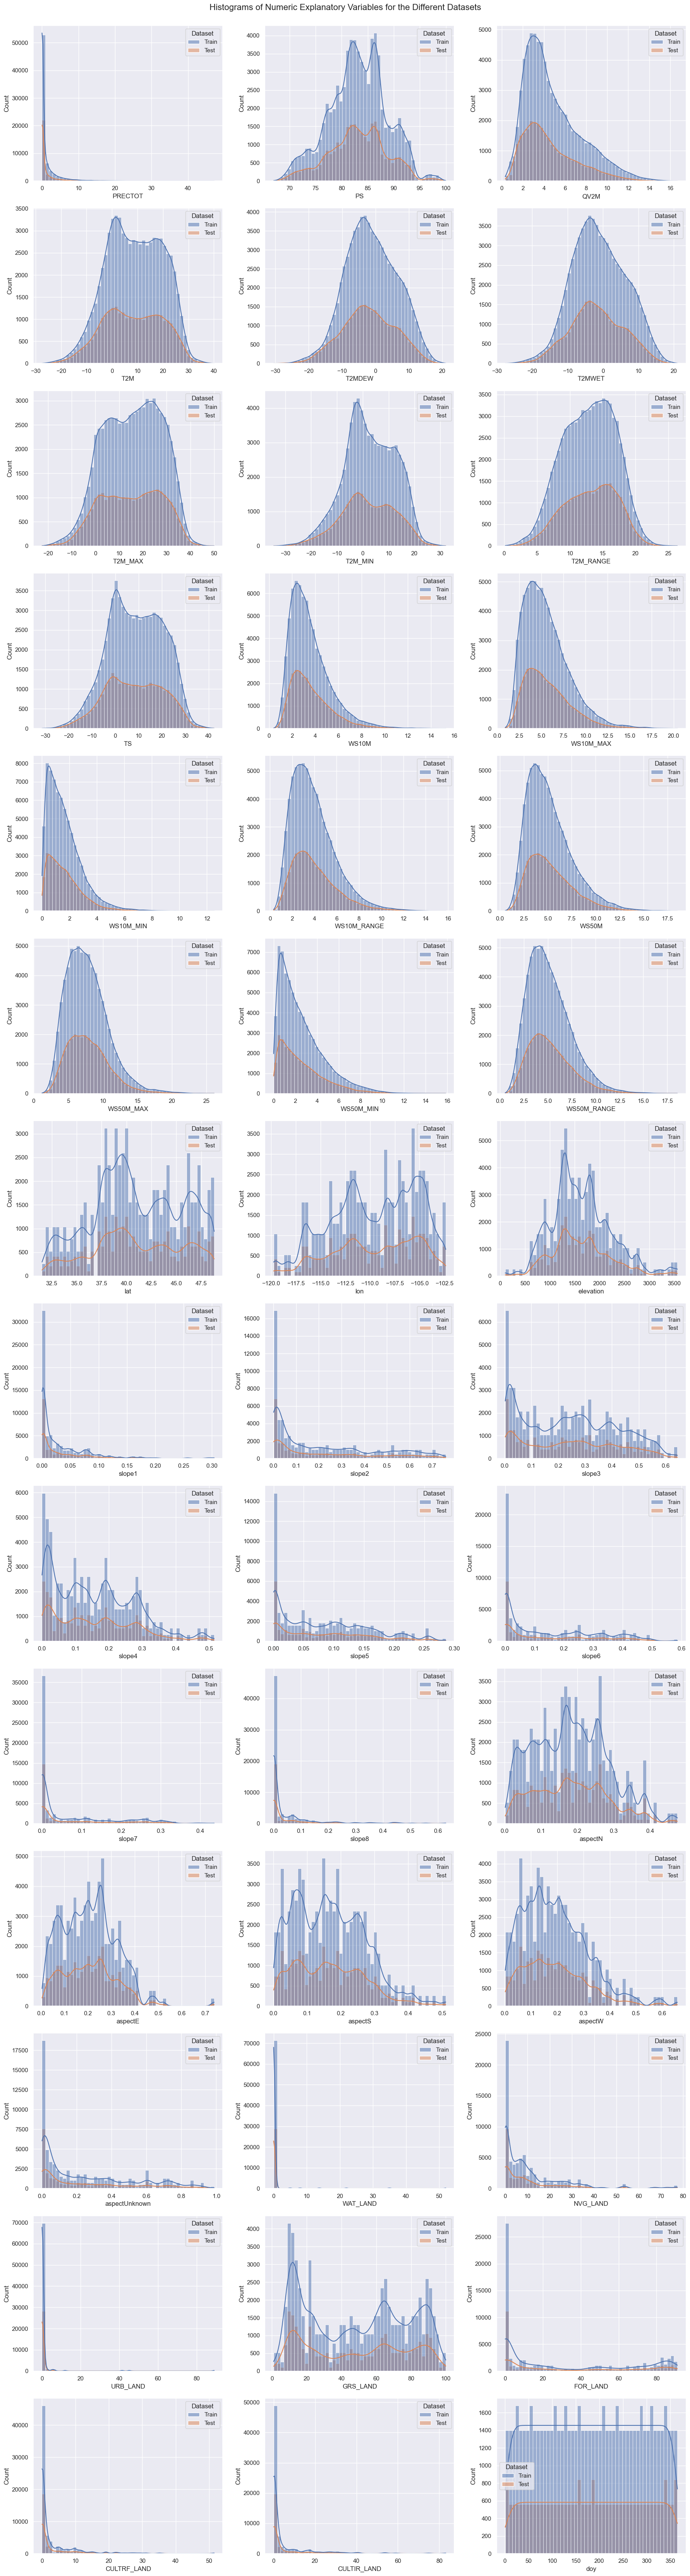

In [190]:
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

# Combine the observations of Train and Test, identifying them with a column
X_train_num['Dataset'] = 'Train'
X_test_num['Dataset'] = 'Test'
X_num_combined = pd.concat([X_train_num, X_test_num], ignore_index=True)

variables = X_num_combined.columns.drop('Dataset')  # Exclude the 'Dataset' column
n_cols = 3
n_rows = math.ceil(len(variables) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through selected numeric variables and create histograms for each dataset
for i, variable in enumerate(variables):
    sns.histplot(data=X_num_combined, x=variable, hue='Dataset', ax=axes[i], kde=True, bins=50)

# Remove empty subplots
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Histograms of Numeric Explanatory Variables for the Different Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

To identify **outliers** in the datasets, we used box plots to visualize the distribution of numerical variables, as shown in the figure below. Box plots are effective for identifying outliers because they display a range defined by the interquartile range (IQR) and whiskers that extend up to 1.5 times the IQR from the quartiles. Specifically, the upper whisker extends to Q3 + 1.5 * IQR, and the lower whisker extends to Q1 - 1.5 * IQR. Observations falling outside this whisker's range are typically considered outliers.

Upon examining the plots, we note that numerous variables had flagged observations as outliers. However, when comparing the box plots for the same variable across the different datasets, it become evident that the values flagged as outliers are, in most cases, also present in the other dataset. This implies that these observations may not truly be outliers

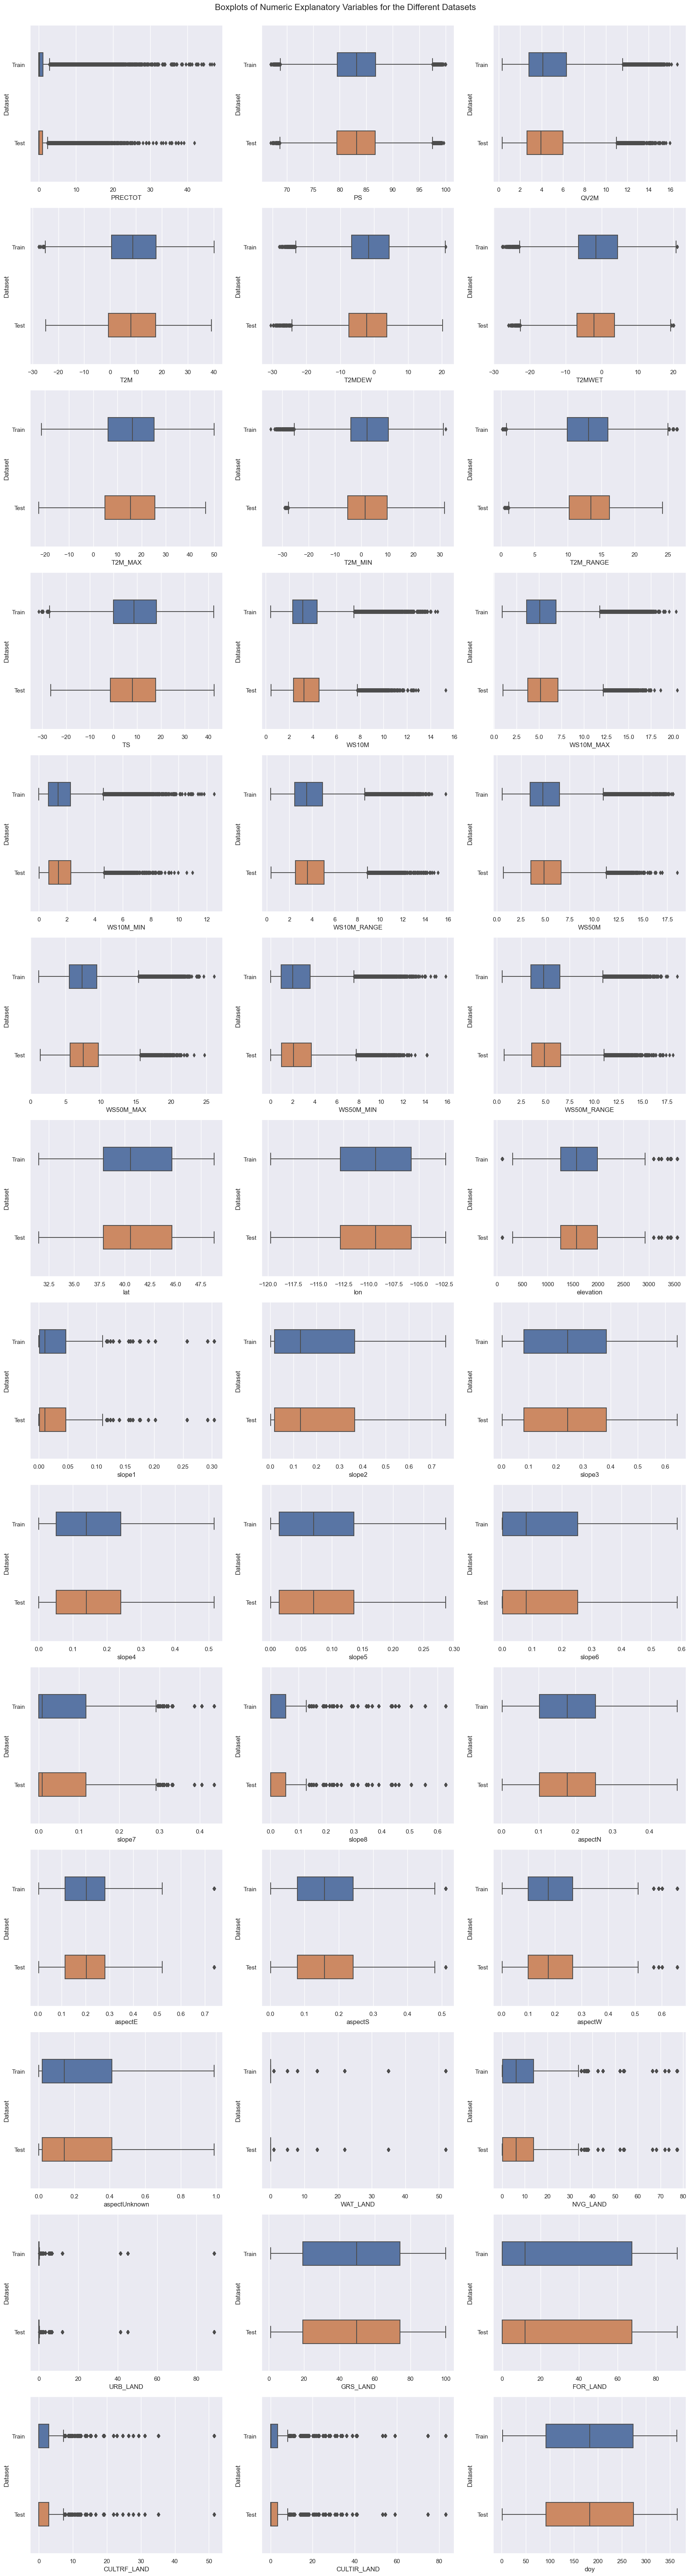

In [191]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through numeric variables and create boxplots for each dataset
for i, variable in enumerate(variables):
    sns.boxplot(data=X_num_combined, x=variable, y='Dataset', ax=axes[i], width=0.3)

# Remove empty subplots
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Boxplots of Numeric Explanatory Variables for the Different Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

#### 4.1.2 Categorical Exploratory Variables
To gain insights into the distribution of Categorical Explonatory variables, we utilized stacked bar charts, as shown in the figure below. These charts specifically offer a clear view of the distribution of observations across the different categories within each dataset.

For the  Soil Quality variables (SQ1 to SQ7), it is verified that not all the categories have associated observations. For instance, Workability (SQ7) lacks observations in category 5, and Toxicity (SQ6) has no values associated with category 4. Across all SQ variables, category 1 stands out as the majority class, while categories 0, 6, and 7 are minority classes. For detailed descriptions of these categories, please refer to Section [1.3 Soil Dataset Loading and Description](#c1.3).

Regarding the year, the plot confirms the pre-split of the data into training (2014 to 2018) and testing (2019 and 2020) based on the year of observation.

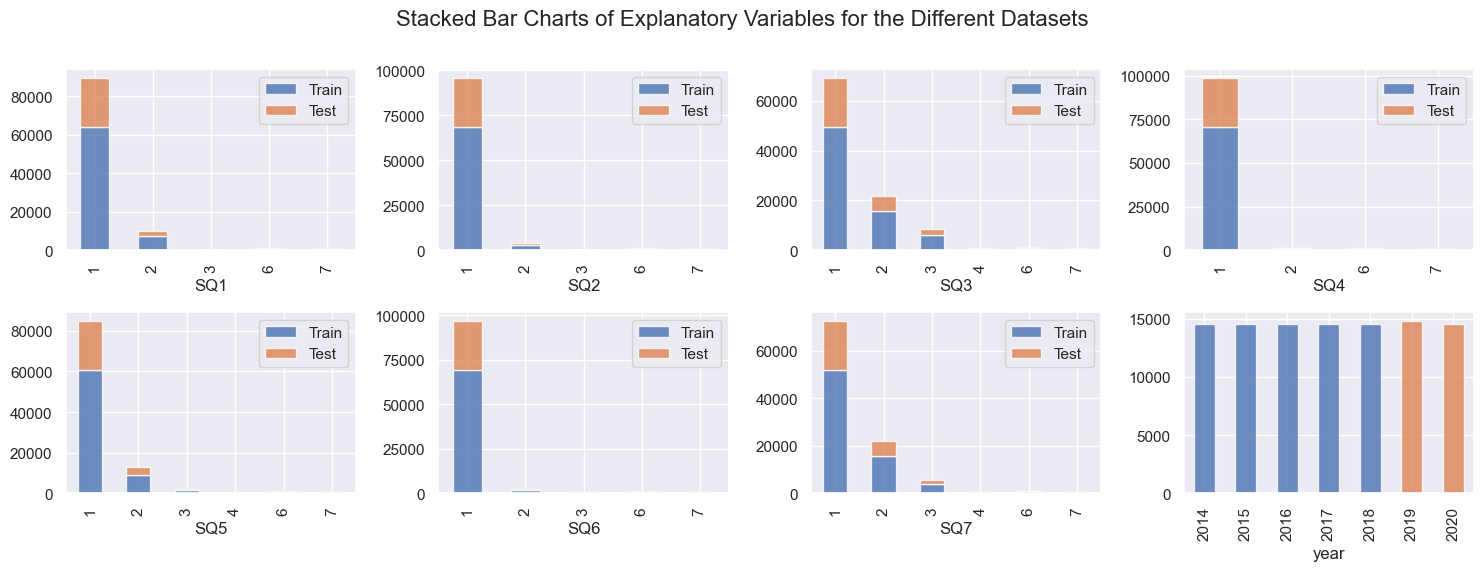

In [192]:
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

# Combine the observations of Train, Val and Test, identifying them with a column
X_train_cat = train_m_df.select_dtypes(include=['int64','uint8']).drop(columns=['fips','score','doy'])
X_train_cat = X_train_cat[X_train_cat['year'] >= 2014]
X_test_cat = test_m_df.select_dtypes(include=['int64','uint8']).drop(columns=['fips','score', 'doy'])

X_train_cat['Dataset'] = 'Train'
X_test_cat['Dataset'] = 'Test'
X_cat_combined = pd.concat([X_train_cat, X_test_cat], ignore_index=True)

variables = X_cat_combined.columns.drop('Dataset')

n_cols = 4
n_rows = math.ceil(len(variables) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,n_rows * 3))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Iterate through numeric variables and create boxplots for each dataset
for i, variable in enumerate(variables):
    crosstab_data = pd.crosstab(index=X_cat_combined[variable], columns=X_cat_combined['Dataset'])
    # Reorder categories
    crosstab_data = crosstab_data[['Train', 'Test']]
    ax = crosstab_data.plot(kind='bar', stacked=True, alpha=0.8, ax=axes[i % len(axes)])  # Add alpha for transparency
                       
    # Hide the legend if it overlaps with bars
    if i % len(axes) <7:
        ax.legend(loc='upper right')
    else:
        ax.get_legend().remove()

# Remove empty subplots
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('Stacked Bar Charts of Explanatory Variables for the Different Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

#### 4.1.3 Categorical Target Variable

As outlined in Section [2. Definition of Prediction Problem](#c2), our target variable is "score," which we transformed into a discrete variable with five categories (Section [3.6 Reformat of specific explonatory variables and target variable](#c3.6)) representing different levels of drought.

To examine the distribution of observations within each target category, the figure below displays countplots for each dataset. It is evident that there is an imbalance in both datasets, where the majority class corresponds to "No Drought," while the minority classes signify the presence of drought. Specifically, as the severity of drought increases, the number of observations decreases.

Given this imbalance, our upcoming milestones will involve exploring the implementation of oversampling techniques to address this issue.

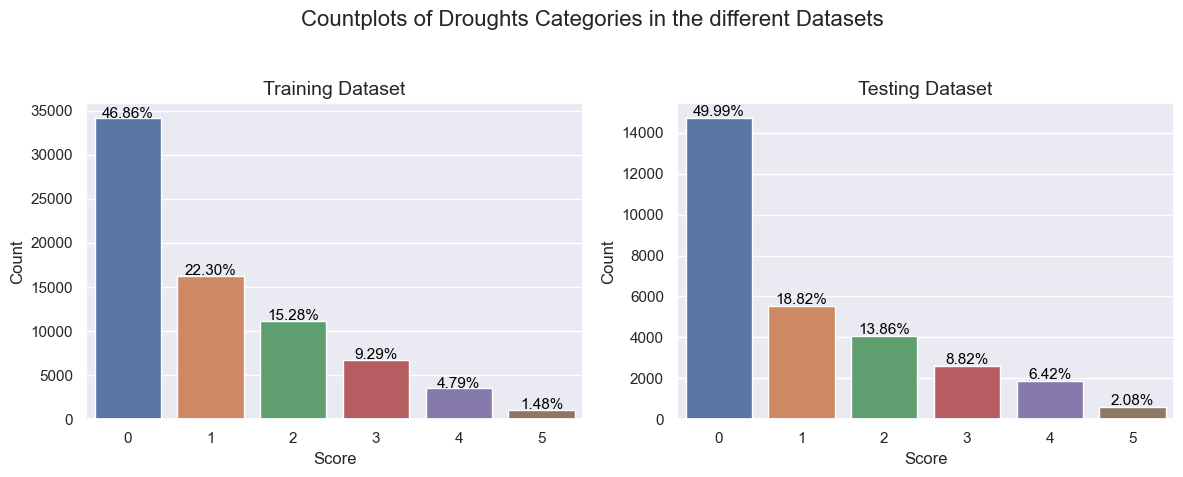

In [193]:
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iterate through the target variables and their corresponding names
target_vars = [y_train, y_test]

for i, (target, target_name) in enumerate(zip(target_vars, datasets_names)):
    # Plot countplot for 'score' in the current target variable
    ax = sns.countplot(x=target, ax=axes[i])
    ax.set_title(target_name, fontsize=14)
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    
    # Annotate each bar with the count
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / len(target)) * 100
        ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height+100), ha='center', fontsize=11, color='black')

fig.suptitle('Countplots of Droughts Categories in the different Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### 4.2 Bivariate Data Analysis <a id='c4.2'></a>
Considering the prior confirmation during Univariate Data Analysis that the Training, Validation, and Testing datasets exhibit similar distributions, we exclusively utilized the Training Dataset for the Bivariate Data Analysis.

Initially, to assess the correlation among all the Exploratory Variables, we generated a correlation matrix plot. Based on it,  it is verified that several variables exhibit a strong positive correlation, denoted by red values with a correlation coefficient exceeding 0.98. It raises concerns about potential multicollinearity among these variables , which can have significant implications when training machine learning models.

Multicollinearity can distort the estimated coefficients of the correlated variables, making it challenging to determine their individual contributions to the model's predictions. This can result in reduced interpretability of the model.

Examples of highly correlated variables (with correlation values exceeding 0.98) include:

* T2M_WET and T2M_DEW
* T2M_MAX, T2M_MIN, and T2M
* TS and T2M
* TS and T2M_MAX

While it may initially seem reasonable to assume multicollinearity among variables like T2M_MAX, T2M_MIN, and T2M since they are all related to temperature at a 2-meter height, a more in-depth examination is required. For instance, when we examine variables such as WS10M_MAX, WS10M_MIN, and WS10M, which are associated with wind speed at 10 meters, as well as WS50M_MAX, WS50M_MIN, and WS50M, representing wind speed at 50 meters, we find positive correlations among them, but with coefficients lower than 0.90. This suggests that while there is some correlation, the maximum and minimum values for wind speeds may not necessarily provide redundant information when compared to WS10M or WS50M.

Therefore, before making any decisions about eliminating variables due to multicollinearity, it is imperative to acquire further domain knowledge. In the next phase of our analysis, we will seek additional information to better understand which variables are capturing the same underlying phenomena and can potentially be omitted to avoid redundancy in our model. 

In [194]:
# Correlation Matrix
corr_plot = train_df.corr(numeric_only=True)
corr_plot.style.background_gradient(vmin=-1, vmax=1,cmap = 'RdBu_r')

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,aspectN,aspectE,aspectS,aspectW,aspectUnknown,WAT_LAND,NVG_LAND,URB_LAND,GRS_LAND,FOR_LAND,CULTRF_LAND,CULTIR_LAND,doy,year,SQ1_2,SQ1_3,SQ1_6,SQ1_7,SQ2_2,SQ2_3,SQ2_6,SQ2_7,SQ3_2,SQ3_3,SQ3_4,SQ3_6,SQ3_7,SQ4_2,SQ4_6,SQ4_7,SQ5_2,SQ5_3,SQ5_4,SQ5_6,SQ5_7,SQ6_2,SQ6_3,SQ6_6,SQ6_7,SQ7_2,SQ7_3,SQ7_4,SQ7_6,SQ7_7
PRECTOT,1.000000,-0.028706,0.241161,-0.045794,0.217960,0.216626,-0.115207,0.019083,-0.392051,-0.033102,0.027056,0.028322,0.013015,0.028306,0.022193,0.024662,0.024283,0.010706,-0.053303,0.073762,-0.014303,0.016308,-0.024908,-0.036670,-0.051449,-0.026733,0.015333,0.053838,0.067120,0.051998,0.015427,0.023197,0.036605,0.012324,-0.035460,0.009354,-0.092335,0.000325,-0.046458,0.072189,0.026782,0.000423,0.001908,-0.024938,0.003104,0.026054,0.007277,-0.005340,0.036420,0.026054,0.007277,-0.005340,-0.015418,-0.009851,0.009082,0.007277,-0.005340,0.001713,0.007277,-0.005340,-0.041205,-0.013587,-0.007972,0.007277,-0.005340,-0.025324,-0.013809,0.007277,-0.005340,-0.013551,-0.005620,0.005112,0.007277,-0.005340
PS,-0.028706,1.000000,0.123218,0.211689,0.224884,0.227925,0.180788,0.241724,-0.054328,0.217924,0.138267,0.125577,0.092510,0.103060,0.109874,0.143240,0.059064,0.137302,0.007068,0.290477,-0.135878,-0.906986,0.265356,0.339911,0.247094,0.000658,-0.263314,-0.373093,-0.290047,-0.258007,-0.192885,-0.229907,-0.197603,-0.192870,0.334868,0.019358,0.207773,-0.064181,0.405682,-0.496243,0.307398,0.044545,0.008857,0.003205,0.129961,0.076925,-0.236495,0.038023,0.075167,0.076925,-0.236495,0.038023,-0.241145,-0.076132,-0.083104,-0.236495,0.038023,-0.069387,-0.236495,0.038023,0.082721,-0.024645,0.009458,-0.236495,0.038023,0.086541,-0.008958,-0.236495,0.038023,-0.168704,-0.134040,-0.134949,-0.236495,0.038023
QV2M,0.241161,0.123218,1.000000,0.760613,0.957974,0.960700,0.703974,0.797446,0.142853,0.760315,-0.165267,-0.129604,-0.187905,-0.046648,-0.180064,-0.127727,-0.190575,0.003996,-0.027524,-0.076327,0.081590,-0.100935,0.054289,0.087063,0.043086,-0.033807,-0.062436,-0.070697,-0.056223,-0.044879,-0.048208,-0.050299,-0.051337,-0.052424,0.083325,0.014520,-0.024501,-0.001456,0.074997,-0.055778,-0.004195,0.006076,0.148839,-0.041013,0.004559,0.006418,-0.027550,0.007979,0.015503,0.006418,-0.027550,0.007979,-0.013649,-0.015736,-0.015392,-0.027550,0.007979,-0.003628,-0.027550,0.007979,0.029573,-0.010317,-0.006223,-0.027550,0.007979,0.008561,0.008934,-0.027550,0.007979,-0.019798,-0.011684,-0.016862,-0.027550,0.007979
T2M,-0.045794,0.211689,0.760613,1.000000,0.814730,0.819456,0.987861,0.982975,0.535771,0.995342,-0.090031,-0.023337,-0.172196,0.080965,-0.112465,-0.031956,-0.186232,0.128002,0.136128,-0.254643,0.033119,-0.194904,0.098859,0.164988,0.121444,-0.007633,-0.099404,-0.164353,-0.161355,-0.129066,-0.097495,-0.082010,-0.122571,-0.083587,0.157185,0.003039,0.172314,0.000502,0.148695,-0.185735,-0.081838,0.005111,0.144959,0.001073,0.035626,-0.014108,-0.063242,0.015752,-0.037205,-0.014108,-0.063242,0.015752,0.012428,0.010860,-0.034614,-0.063242,0.015752,-0.004146,-0.063242,0.015752,0.133622,0.022195,0.012656,-0.063242,0.015752,0.076783,0.035652,-0.063242,0.015752,0.009083,0.000052,-0.041780,-0.063242,0.015752
T2MDEW,0.217960,0.224884,0.957974,0.814730,1.000000,0.999519,0.757596,0.850426,0.172864,0.812835,-0.141068,-0.102414,-0.173043,-0.020999,-0.148315,-0.091478,-0.172527,0.035899,-0.029763,-0.017828,0.024191,-0.197550,0.073664,0.104792,0.055303,-0.025478,-0.074728,-0.093686,-0.072328,-0.064235,-0.061454,-0.065615,-0.061437,-0.059079,0.101781,0.016933,0.000984,-0.008162,0.102498,-0.099984,0.032934,0.017671,0.144015,-0.036954,0.018231,0.017553,-0.056779,0.016087,0.021614,0.017553,-0.056779,0.016087,-0.044736,-0.021800,-0.021187,-0.056779,0.016087,-0.008414,-0.056779,0.016087,0.032572,-0.009101,-0.001617,-0.056779,0.016087,0.016509,0.004972,-0.056779,0.016

Similarly, to narrow our focus exclusively to the correlation between the explanatory variables and the target variable, we have constructed a plot displaying the correlation values of each explanatory variable with the drought score.

None of the variables exhibit a positive or negative correlation exceeding 0.3. This observation suggests that, initially, we cannot draw definitive conclusions regarding the relative importance of these variables in determining the drought score. However, it is noteworthy that the variables with the highest positive correlation values are NVG_LAND (Barren/very sparsely vegetated land) and SQ5_2. Conversely, the variables lat and log have the most negative correlations.

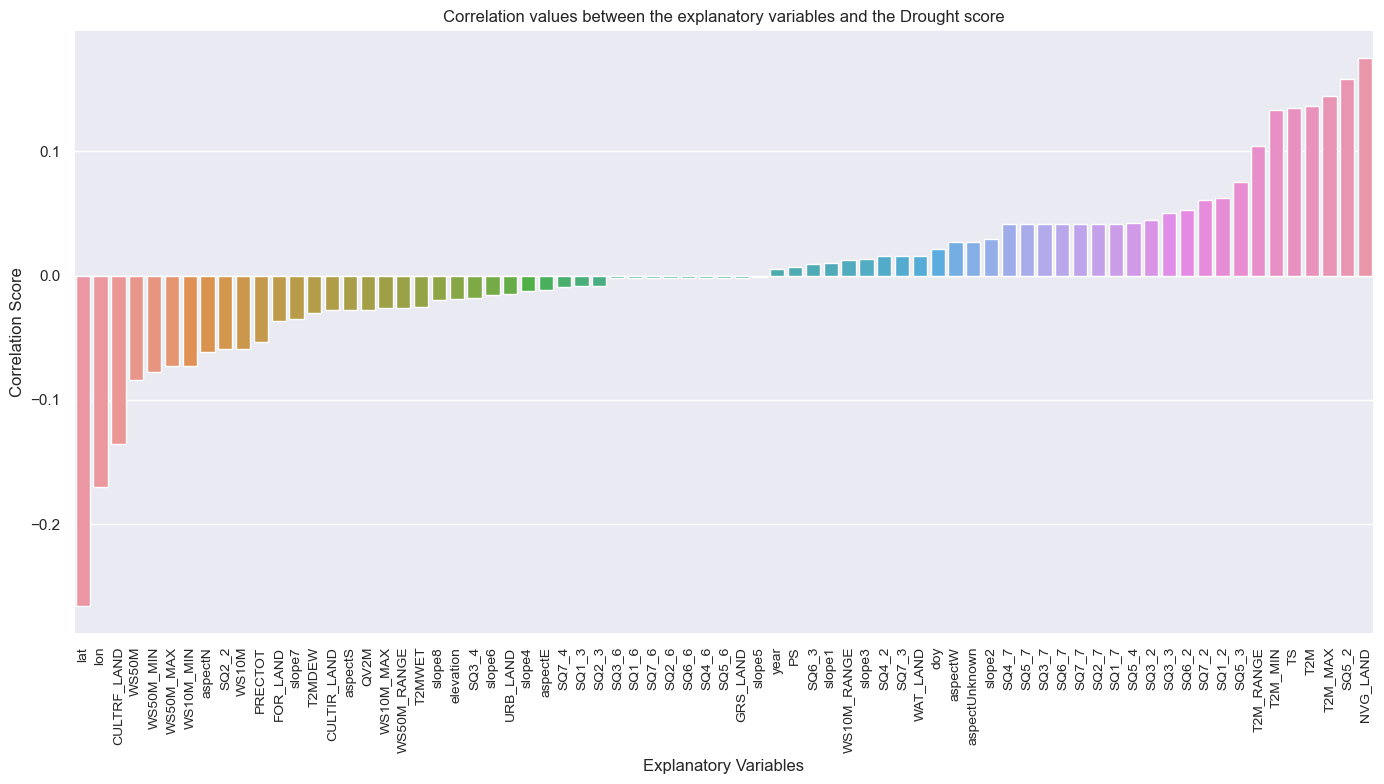

In [195]:
# Set Seaborn style to "dark"
sns.set(style='darkgrid')

plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(
    x=corr_plot['score'].sort_values().iloc[:-1].index,
    y=corr_plot['score'].sort_values().iloc[:-1].values
)

# Add x and y labels
plt.xlabel("Explanatory Variables")  # Add x-label
plt.ylabel("Correlation Score")  # Add y-label

plt.title("Correlation values between the explanatory variables and the Drought score")
plt.xticks(rotation=90, fontsize=10)  # Adjust the font size and rotation as needed

plt.tight_layout()  # Add this line to improve spacing between x-axis labels
plt.show()

### 4.3 Data Standardization <a id='c4.3'></a>

The explanatory variables are standardized to account their different scales. This standardization step is helpful when applying machine learning algorithms like Logistic Regression as it enhances the convergence of the gradient descent process. Additionally, it has no adverse effects on the results of machine learning algorithms that don't utilize gradient descent, such as Random Forest. Lastly, it enables a direct comparison of model coefficients.

In the code below, the mean and standard deviation statistics are calculated using the .fit() method exclusively on the training dataset. This approach safeguards against data leakage and ensures that prior knowledge of the testing set is avoided.  Subsequently, the training and test datasets are actually scaled using the .transform() method.

In [29]:
# Create a StandardScaler object to standardize the data.
scaler = StandardScaler()
# Fit the scaler to the training data to compute mean and standard deviation.
scaler.fit(X_train)
# Transform the training data using the computed mean and standard deviation.
scaled_X_train = scaler.transform(X_train)
# Transform the test data using the same scaler.
scaled_X_test = scaler.transform(X_test)

***
## 5. Evaluation Protocol <a id='c5'></a>
***

### 5.1 Proposed Evaluation Protocol Description
For the **upcoming milestones**, we propose the following Evaluation Protocol:

![Evaluation_Protocol](img/Evaluation_Protocol.png)

*Figure: Modified from Francois Fleuret, EE559 Deep Learning, EPFL*

1. **Train-Validation-Test Split**:
   - The dataset is already divided into two subsets: training and test sets.

2. **Hyperparameter Tuning**:
   - Cross-validation will be applied to both the training datasets for hyperparameter optimization. This step ensures that hyperparameters are chosen without introducing data leakage from the test set.

3. **Hyperparameter Selection**:
   - Based on the results obtained from the cross-validation, the best hyperparameters will be selected.

4. **Final Model Training**:
   - The model will be retrained using the entire training dataset, incorporating the selected hyperparameters.

5. **Test Set Evaluation**:
   - The final model's true performance metrics will be calculated using the untouched test dataset. This step will provide an unbiased assessment of the model's generalization capability to unseen data.

6. **No Further Hyperparameter Adjustments**:
   - There will not be additional adjustments to the hyperparameters following the evaluation on the test dataset. This ensures that the model's performance estimate remains reliable without overfitting to the test set.

### 5.2 Performance Metric
Given the dataset's class imbalance, calculating accuracy alone can be misleading. Accuracy measures the ratio of correct predictions to total predictions and can lead to inflated scores when dealing with imbalanced datasets, where a model can achieve high accuracy by simply predicting the dominant class for every observation.

To address this, the F1 score is selected as the primary metric of interest. It takes into account both precision and recall, making it well-suited for imbalanced datasets. Specifically, since the prediction task involves multiclass classification, the **F1 score macro** metric will be employed in our experiments. Unlike the "F1 score micro" which gives more weight to the majority class due to its larger sample size, the "F1 score macro" metric treats all classes equally. This ensures a fair evaluation of model performance without favoring the dominant class.

In addition, classification reports will be generated to assess the F1 score for each individual class. This allows for a direct comparison of the model's performance on the minority classes associated with Drought occurrences.

Furthermore, **Precision-Recall (PR)** curves will be constructed for each class, and their respective **Area Under the Curve (AUC)** will be calculated as an additional metric for model comparison. This approach is preferred over Receiver Operating Characteristic (ROC) curves for imbalanced datasets, as ROC curves can be overly optimistic in severely imbalanced classification problems with limited samples of the minority class (Brownlee, 2020b).

# Milestone 2

**Adaptation of recommendations**

The date was formatted appropriately to the day of the year and year to make it suitable for use in the model.

**Methodology modifications**

The challenges posed by the size of our dataset required us to adapt our approach in conducting exploratory analyses. These adaptations encompassed several key modifications:

1. **Concatenation of Training and Validation Data:** To accommodate our chosen sklearn cross-validation methodology, which doesn't readily support the use of both training and validation datasets, we had to concatenate these datasets.

2. **Geographic Filter:** We initially employed a geographical filter as the first step in our data processing. This filter restricted our analysis to the Western mountain regions of the United States, an area known for its high prevalence of drought, according to data from the National Integrated Drought Information System.

3. **Year Limitation:** Subsequent to the concatenation of data, our study's temporal scope shifted. While the original dataset spanned from 2008 to 2018, we narrowed our focus to the years 2014 to 2018

4. **Statistical Analyses and Plots:** As a result of the aforementioned modifications, our statistical analyses and data visualizations underwent adjustments to align with the revised dataset and focus. Nonetheless, the core interpretations and objectives remained consistent throughout these changes.

Making those modifications was absolutely essential as we worked towards achieving our next major milestone.

***
## 6. Algorithm Selection <a id='c6'></a>
***

It's essential to acknowledge that our dataset exhibits an imbalanced class distribution. Specifically, the 'No drought' class contains a substantially higher number of examples in comparison to the other classes, which are the minority classes. Given this class imbalance, standard logistic regression models are not be the most suitable choice because these models would learn better on sample of the major classes but generalize poorly pn the minority classes. Therefore, our preferred model is a cost-sensitive multi-class regression model. In making this choice, we took the following considerations into account:

- **Performance Metrics for Minority Classes:** Traditional performance metrics such as accuracy may not adequately represent the model's effectiveness when dealing with imbalanced datasets. Therefore, we focused on performance metrics that place more emphasis on the correct classification of minority classes, such as precision, recall, F1-score, and area under the ROC curve (AUC-ROC).

- **Multiclass Strategy:** For a multiclass problem, we have a choice between One-vs-Rest (OvR) and Multinomial. OvR involves fitting a binary classifier for each class, while Multinomial directly models the joint probability of all classes. For a large dataset, both methods can be effective. OvR can be parallelized and may work well with any solver.We experimented with both.

- **Solver Selection:** Because of our large dataset with encoded variables, solvers like sag and saga are recommended. 

- **Class Rebalancing:** To address the class imbalance issue, we explored techniques for rebalancing the dataset. One of the techniques we experimented on was the oversampling of the minority classes using the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE works by generating synthetic examples of the minority class by interpolating between existing minority class instances.


***
## 7. Definition of functions <a id='c7'></a>
***

In [30]:
# Importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from itertools import cycle
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import joblib
import time

In [31]:
# Evaluation of Model's Performance
def evaluate_model_performance(y_true, y_pred):
    """
    Evaluate the performance of the classification model and plot a confusion matrix.

    Parameters:
    - y_true: true labels for the data
    - y_pred: predicted labels from the model
    """
    # Define the class labels
    
    # Generate a classification report
    print(classification_report(y_true, y_pred, target_names=['No Drought', 'D0','D1','D2','D3','D4']))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a ConfusionMatrixDisplay object and plot the confusion matrix
    sns.set(style='dark')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Drought', 'D0','D1','D2','D3','D4'])
    plt.figure(figsize=(4, 4))
    disp.plot()

In [32]:
# Precision Recall curves per class
# Based on https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
# Additional Resources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
def plot_precision_recall_curves(model, X_test, y_test):
    """
    Generate and plot a Precision-Recall curve for a multi-class classification model.

    Parameters:
    model (estimator): The classification model for which the Precision-Recall curve is generated.
    X_test (array-like): The feature matrix of the test data.
    y_test (array-like): The true labels of the test data.
    """

    # Binarize the true labels for multi-label settings
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
    n_classes = y_test.shape[1]

    # Calculate the decision function scores
    y_score = model.decision_function(X_test)

    # Initialize dictionaries to store precision and recall values
    precision = dict()
    recall = dict()

    # Calculate precision and recall for each class
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(['No Drought', 'D0', 'D1', 'D2', 'D3', 'D4'][i]))

    # Set axis labels and legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision-Recall curve per class")
    plt.show()

***
## 8. Proposed Workflow <a id='c8'></a>
***
The diagram below illustrates the workflow for this milestone. Initially, four models were explored: M1, M2, M3, and M4. M1 and M2 were created without using regularization, while M3 and M4 incorporated regularization. Additionally, as identified in the data exploration conducted during Milestone 1, our dataset is imbalanced. To address this imbalance, two main techniques were employed:

* **Model-level** approach using class weights, as implemented for M1 and M3.
* **Data-level** approach using SMOTE (Synthetic Minority Over-sampling Technique), as made for M2 and M4.

Based on the performance and timing of these models, we selected the initial model. Subsequently, the primary model's hyperparameters were fine-tuned to achieve the final model.

![Workflow_LR](img/Workflow_LR.jpg)

To begin with the Proposed Workfow, the table below outlines the parameters **shared** among the models along with their respective explanations:

| Parameter Name         | Selected Value | Explanation                                                                                                  |
|-----------------------|-----------------|--------------------------------------------------------------------------------------------------------------|
| `dual`                  | default=False   | Set to `False` as `n_samples` is greater than `n_features` in the dataset.                       |
| `tol`                   | default=1e-4    | The tolerance for stopping criteria is left at the default value to ensure a balance between convergence speed and good performance.  |
| **`C`**                     | default=1.0     | The default value for `C` is chosen as the baseline, but it will be fine-tuned later using cross-validation.  |
| `fit_intercept`         | default=True    | `fit_intercept` is set to `True` because the bias or intercept term is added to the decision function.  |
| `intercept_scaling`     | default=1       | The default value for `intercept_scaling` is retained as it should only be modified when using the 'liblinear' solver with `self.fit_intercept` set to `True`.  |
| `random_state`          | 44              | The `random_state` is fixed at 44 to ensure reproducible shuffling of data when using the 'saga' solver.  |
| **`solver`**                | 'saga'          | 'saga' solver is chosen because it supports both None regularization and regularization with elasticnet and is recommended for faster convergence in large, scaled datasets.  |
| **`max_iter`**              | 5000            | `max_iter` is increased to 5000 from the default 100 to allow convergence in large datasets without overly extended training times.  |
| **`multi_class`**           | 'ovr'           | 'ovr' is selected for multiclass classification as it allows parallelization of model training, suitable for large datasets.  |
| `verbose`               | 2               | `verbose` is set to 2 to receive progress prompts during model training.  |
| `warm_start`            | default=False   | `warm_start` is kept at its default value as it's the first fit of each model.  |
| `n_jobs`                | -1              | `n_jobs` is set to -1, utilizing all processors for parallelization when 'ovr' is selected.  |

***
## 9. Logistic Regression without Regularization <a id='c9'></a>
***

It is important to notice that scikit-learn applies L2 regularization penalty by default. Then, for M1 and M2:

| Parameter Name | Selected Value | Explanation                                             |
|-----------------|-----------------|---------------------------------------------------------|
| **`penalty`**        | None            | To evaluate model's behavior without any regularization penalty. |


### 9.1 Model 1 (M1): Managing class imbalance with Model Weights <a id='c9.1'></a>

In line with the Workflow described earlier, our approach for models M1 and M3 involves addressing class imbalance at the model level. Specifically, for Logistic Regression, this can be accomplished using the `class_weight` parameter. By default, this parameter is set to `None`, meaning that all classes are assigned equal weight, as indicated in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Consequently, we made the following adjustment:

| Parameter Name  | Selected Value | Explanation                                             |
|------------------|-----------------|---------------------------------------------------------|
| **`class_weight`** | balanced       | We set it to 'balanced' to modify the weights inversely proportional to the class frequencies in the input data, using the formula: `n_samples / (n_classes * np.bincount(y))`, as outlined in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).|


**Result M1:**  In the code cell below, as indicated by the associated prompts, the model attempted to converge for a duration of 8 minutes. However, it was unable to do it within the specified number of iterations. We decided not to increase the number of iterations, given that the model already requires a substantial amount of time to converge with the current settings. Our goal is to select a model that can be fine-tuned using a grid of parameters, which would involve training the model multiple times with different combinations of parameters. This implies that each combination of parameters would also take approximately 8 minutes to complete.

In [52]:
start = time.time()
clf1 = LogisticRegression(class_weight='balanced',penalty=None, solver='saga', multi_class='ovr',
                          max_iter=5000, verbose=2, n_jobs=-1, random_state=44)
clf1.fit(scaled_X_train, y_train)
end = time.time()
print("Execution time for Training:", end - start, "seconds")
# Save the trained model
joblib.dump(clf1, 'model1_FINAL_ovr.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 615 epochs took 70 seconds
convergence after 620 epochs took 72 seconds
max_iter reached after 490 seconds


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  8.2min remaining:  8.2min


max_iter reached after 492 seconds
max_iter reached after 493 seconds
max_iter reached after 493 seconds
Execution time for Training: 493.73252964019775 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  8.2min finished


['model1_FINAL_ovr.pkl']

In [ ]:
#clf1 = joblib.load('model1_FINAL_ovr.pkl')

### 9.2  Model 2 (M2): Managing class imbalance with SMOTE <a id='c9.2'></a>
On the other hand, the idea for M2 and M4 is to address the imbalance in a data level. Then, `class_weight` parameter was not modified from the default value `None`, but the data was oversampled on the minority classes. 

Addressing class imbalance can be achieved by duplicating instances within the minority class. But, this replication method may not substantially enrich the model's knowledge. A more efficient approach is to create synthetic instances based on existing examples, which can be viewed as a form of data augmentation for the minority class (Brownlee, 2020b). This approach is known as the Synthetic Minority Oversampling Technique (SMOTE).

"SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b" (He & Ma, 2013)

The imbalanced-learn library implements the SMOTE approach to oversample the minority classes and balance the dataset with the majority class. When using SMOTE, it should be applied only to the **training dataset** and not the testing dataset.

In [33]:
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
sm = SMOTE(random_state=44)
smote_X_train, smote_y_train = sm.fit_resample(scaled_X_train, y_train)

After applying SMOTE, a countplot was generated for the Training Dataset to confirm that there is an equal number of samples in each class.

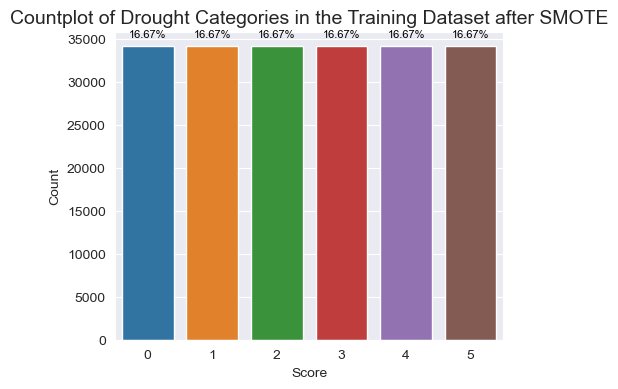

In [34]:
# Create a countplot to display the new distribution after SMOTE
# Set Seaborn style to "dark"
sns.set_style("darkgrid")

plt.figure(figsize=(5,4))
ax = sns.countplot(x=smote_y_train)
ax.set_title('Countplot of Drought Categories in the Training Dataset after SMOTE', fontsize=14) 

# Set the axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Count')

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(smote_y_train)) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height + 1000), ha='center', fontsize=8, color='black')

**Result M2**: Similar to the behavior of M1, this model also did not converge within the 5000 defined iterations. However, the time spent was significantly higher, taking 29.1 minutes to reach the maximum number of iterations. As before, this model does not represent an optimal solution.

In [56]:
start = time.time()
clf2 = LogisticRegression(penalty=None, solver='saga', multi_class='ovr',
                          max_iter=5000, verbose=2, n_jobs=-1, random_state=44)
clf2.fit(smote_X_train, smote_y_train)
end = time.time()
print("Execution time for Training:", end - start, "seconds")
# Save the trained model
joblib.dump(clf2, 'model2_FINAL_ovr.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 437 epochs took 152 seconds
convergence after 704 epochs took 246 seconds
max_iter reached after 1638 seconds


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 27.3min remaining: 27.3min


max_iter reached after 1676 seconds
max_iter reached after 1720 seconds
max_iter reached after 1747 seconds
Execution time for Training: 1747.3872797489166 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 29.1min finished


['model2_FINAL_ovr.pkl']

In [ ]:
#clf2 = joblib.load('model2_FINAL_ovr.pkl')

***
## 10. Logistic Regression with Regularization <a id='c10'></a>
***
Unlike M1 and M2, M3 and M4 utilize regularization. Specifically, we chose Elasticnet because it combines both L1 (Lasso) and L2 (Ridge) regularization. Given the high dimensionality of our dataset, L1 helps in variable selection by limiting the size of coefficients and potentially setting some to a value of 0. Meanwhile, we also incorporate L2 to make the model more generalizable to unseen data by reducing the risk of overfitting to training data (introducing bias to reduce variance).

Additionally, during the hyperparameter tuning phase, we can adjust the `l1_ratio` hyperparameter for Elasticnet. This will allow us to determine whether L1 or L2 has a greater influence on the model. When l1_ratio is closer to 0, it measn that L2 has a more prominent role in the model, while a value closer to 1 suggests that L1 is the dominant factor.

| Parameter Name | Selected Value | Explanation                                             |
|-----------------|-----------------|---------------------------------------------------------|
| **`penalty`**        | 'elasticnet'            | The penalty is set to 'elasticnet,' which combines the effects of both L1 (Lasso) and L2 (Ridge) regularization. |
| **`l1_ratio`**        | 'elasticnet'            | The `l1_ratio` is specified when working with Elasticnet regularization. It controls the balance between L1 (Lasso) and L2 (Ridge) regularization. We chose an initial value of 0.5 as it considers a balance between the benefits of both L1 and L2 regularization. |

### 10.1  Model 3 (M3): Managing class imbalance with Model Weights <a id='c10.1'></a>

**Result M3:**  Despite setting the regularization and balancing the classes with the model's weights, it still failed to converge, taking 10.9 minutes to reach the maximum allowed iterations.

In [57]:
# This model was run in other computer
start = time.time()
clf3 = LogisticRegression(class_weight='balanced',penalty='elasticnet', solver='saga', multi_class='ovr',
                          max_iter=5000, l1_ratio=0.5, verbose=2, n_jobs=-1, random_state=44)
clf3.fit(scaled_X_train, y_train)
end = time.time()
print("Execution time for Training:", end - start, "seconds")
# Save the trained model
joblib.dump(clf3, 'model3_FINAL_ovr.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 406 epochs took 73 seconds
convergence after 440 epochs took 79 seconds
convergence after 559 epochs took 93 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.5min remaining:  1.5min


max_iter reached after 636 seconds


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 651 seconds
max_iter reached after 653 seconds
Execution time for Training: 652.3895103931427 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 10.9min finished


['model3_FINAL_ovr.pkl']

In [ ]:
#clf3 = joblib.load('model3_FINAL_ovr.pkl')

### 10.2 Model 4 (M4): Managing class imbalance with SMOTE <a id='c10.2'></a>

**Result M4:**   In contrast to the previous models, M4, which incorporates Elastic Net regularization and addresses class imbalance with SMOTE, successfully converged in 2.4 minutes. Given this favorable outcome, M4 has been chosen as the initial model for further tuning in the next section, with the aim of improving its performance.

In [59]:
# This model was run in other computer
start = time.time()
clf4 = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='ovr',
                          max_iter=5000, l1_ratio=0.5, verbose=2, n_jobs=-1, random_state=44)
clf4.fit(smote_X_train, smote_y_train)
end = time.time()
print("Execution time for Training:", end - start, "seconds")
# Save the trained model
joblib.dump(clf4, 'model4_FINAL_ovr.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 276 epochs took 134 seconds
convergence after 289 epochs took 139 seconds
convergence after 303 epochs took 142 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.4min remaining:  2.4min


convergence after 408 epochs took 189 seconds
convergence after 432 epochs took 193 seconds
convergence after 520 epochs took 220 seconds
Execution time for Training: 219.70300483703613 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.7min finished


['model4_FINAL_ovr.pkl']

In [35]:
#clf4 = joblib.load('model4_FINAL_ovr.pkl')

***
## 11. Initial Model <a id='c11'></a>
***
Our model generally struggles to generalize effectively for the minority classes, as evident from the F1-scores and the PR Curves below. This indicates that the model's performance is less satisfactory when it comes to correctly classifying the minority classes in our dataset. This calls for more experimentation to tune our parameters.

              precision    recall  f1-score   support

  No Drought       0.71      0.40      0.51     14698
          D0       0.23      0.15      0.18      5534
          D1       0.13      0.03      0.05      4074
          D2       0.11      0.10      0.10      2594
          D3       0.06      0.21      0.09      1888
          D4       0.04      0.45      0.07       612

    accuracy                           0.26     29400
   macro avg       0.21      0.22      0.17     29400
weighted avg       0.43      0.26      0.31     29400



<Figure size 400x400 with 0 Axes>

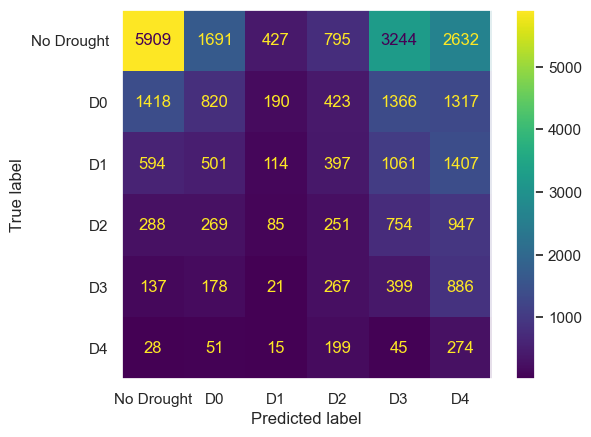

In [60]:
y_pred_clf4= clf4.predict(scaled_X_test)
evaluate_model_performance(y_test, y_pred_clf4)

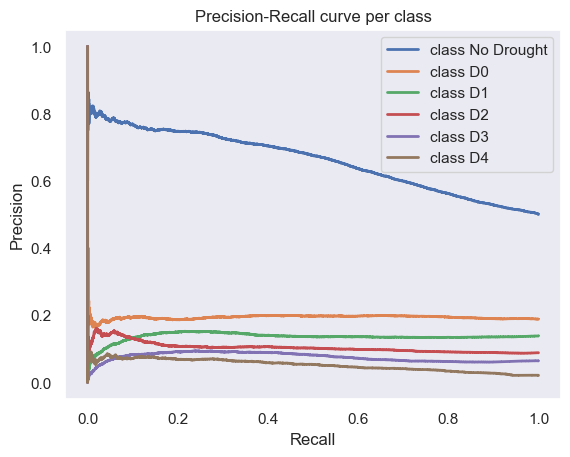

In [62]:
plot_precision_recall_curves(clf4, scaled_X_test, y_test)

***
## 12. Sensitivity to Regularization hyperparameter C <a id='c12'></a>
***
Before tuning the model, this section actually explores the influence over the initial model coefficients of the `C` hyperparameter

- **`C`**:  determines how much regularization is applied to the model, with smaller values emphasizing stronger regularization.

In the code below,  we evaluated M4  using five different values of the parameter `C`. We stored the model coefficients corresponding to each C value in an array. In this case, we set the `warm_start` parameter to `True` in order to reuse the previous fit operation within the loop. The choice of `C` values was determined using a logarithmic scale because it can take a broad range of positive values.

In [139]:
cs = np.logspace(-4, 4, 5)

clf_cs = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='ovr',
                          max_iter=5000, l1_ratio=0.5, verbose=2, warm_start=True, n_jobs=-1, random_state=44)

coefs_cs = []
for c in cs:
    clf_cs.set_params(C=c)
    clf_cs.fit(smote_X_train, smote_y_train)
    coefs_cs.append(clf_cs.coef_.ravel().copy())

coefs_cs = np.array(coefs_cs)
coefs_cs

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 12 epochs took 5 seconds
convergence after 14 epochs took 6 seconds
convergence after 15 epochs took 6 seconds
convergence after 15 epochs took 6 seconds
convergence after 15 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.0s remaining:    6.0s


convergence after 16 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 15 epochs took 7 seconds
convergence after 19 epochs took 8 seconds
convergence after 55 epochs took 23 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   22.3s remaining:   22.3s


convergence after 72 epochs took 28 seconds
convergence after 74 epochs took 30 seconds
convergence after 79 epochs took 31 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   30.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 272 epochs took 124 seconds
convergence after 286 epochs took 132 seconds
convergence after 302 epochs took 135 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.3min remaining:  2.3min


convergence after 396 epochs took 168 seconds
convergence after 434 epochs took 181 seconds
convergence after 525 epochs took 205 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 219 epochs took 104 seconds
convergence after 591 epochs took 265 seconds
max_iter reached after 1896 seconds


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 31.6min remaining: 31.6min


max_iter reached after 1903 seconds
max_iter reached after 1942 seconds
max_iter reached after 1947 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 32.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 13 epochs took 5 seconds
convergence after 43 epochs took 17 seconds
convergence after 2675 epochs took 958 seconds


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 16.0min remaining: 16.0min


convergence after 2709 epochs took 996 seconds
convergence after 3156 epochs took 1123 seconds
convergence after 3406 epochs took 1211 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 20.2min finished


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01465239,  0.        ],
       [-0.06905324, -0.29048757,  0.10399798, ..., -0.04559177,
         0.03039084, -0.04338589],
       [-0.07764414, -0.25973581,  0.18167971, ..., -0.11877271,
         0.02999959, -0.10164594],
       [-0.07757384, -0.25704007,  0.19402468, ..., -0.18252833,
         0.03002182, -0.14059398],
       [-0.07761935, -0.25701228,  0.19406715, ..., -0.18386331,
         0.0300219 , -0.14155158]])

In the following Figure we plotted an elastic net path plot. This represents the relationship between the coefficient values (on the y-axis) and the logarithm (log) of the parameter C (on the x-axis).

* Smaller C Values: the regularization effect is more pronounced leading  to smaller coefficients. This means that as C decreases, the coefficients in the model become sparser and fewer features have significant impact.

* Larger C Values: weaker regularization allowing the model to have coefficients that are less constrained.The coefficients are allowed to grow larger, potentially giving more weight to a broader set of features.

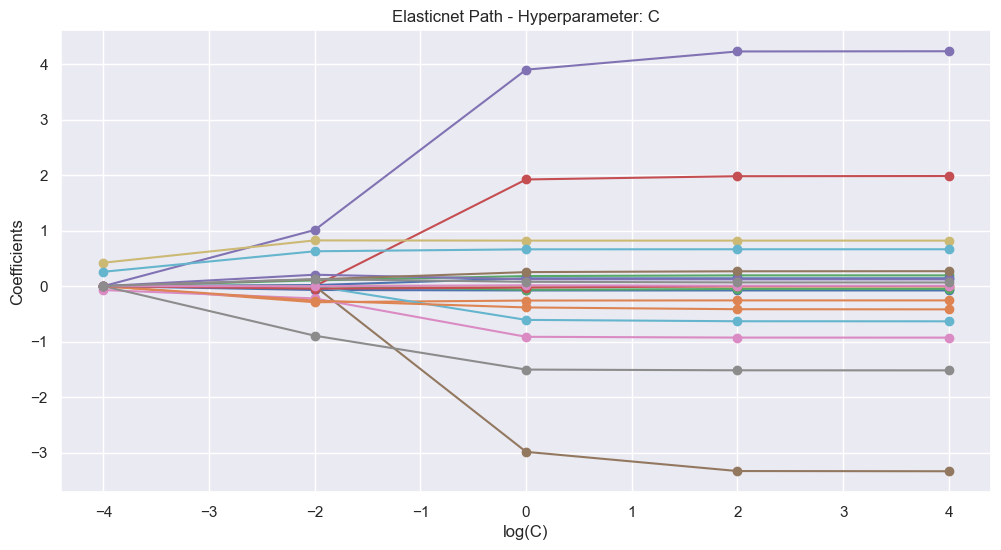

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(np.log10(cs), coefs_cs[:,0:20], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Elasticnet Path - Hyperparameter: C")
plt.axis("tight")
plt.show()

***
## 13. Hyperparameters Tuning <a id='c13'></a>
***

With the objective of actually improving the model's performance, we made use of Grid Search CV. Basically, the two main hyperparameters to tune, which are associated with the regularization, were `C` and `l1_ratio`.

Considering that Grid Search CV is costly, as it attempts to perform cross-validation for all the combinations of parameters input in a grid, only 5 values were defined for `C` and for `l1_ratio`:

- `C` → 0.0001, 0.01, 1.0, 100.0, 10000.0
- `l1_ratio` → 0, 0.25, 0.5, 0.75, 1

Additionally, for the CV, the following main parameters were defined:

| Parameter Name | Selected Value | Explanation |
|-----------------|-----------------|-------------|
| **`estimator`** | clf4 | M4 model |
| **`param_grid`** | clf4 | Dictionary based on the `C` and `l1_ratio` previously presented |
| **`scoring`** | 'f1_macro' | As mentioned during the [3.6 Evaluation Protocol](#c5) Section, the metric used for cross-validation is 'f1_macro', considering that we are dealing with a multiclass problem and it is imbalanced |
| **`cv`** | 3 | The value of the CV splits was reduced from 5 to 3 to save time |
| `verbose` | 5 | To obtain messages with the fold and candidate parameter indexes, along with the starting time of the computation, the value of `verbose` was selected higher than 3, as suggested in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) |
| `return_train_score` | True | To be able to store the computed training scores for further analysis |


**Results Grid CV** As evident from the model's logs, the process was extremely time-consuming, taking more than 5 hours to be completed. Furthermore, there were iterations that failed to converge, resulting in extended processing times without reaching the optimal solution

In [ ]:
#A hyperparameter grid to be used in grid search
cs= np.logspace(-4, 4, 5)
l1_ratios= np.linspace(0,1,5)
param_grid={
    'C': cs,
    'l1_ratio':l1_ratios 
}

# grid search on the parameter space using cross-validation
tscv=TimeSeriesSplit(n_splits=5, gap=12,max_train_size=130000,test_size=20000)
grid_model = GridSearchCV(estimator=clf4, param_grid=param_grid,scoring='f1_macro',cv=tscv, return_train_score=True, verbose=5, n_jobs=1)

# execute the grid search on the training data
grid_model.fit(smote_X_train, smote_y_train)

joblib.dump(grid_model, 'grid_model_FINAL_ovr.pkl')

: 

In [ ]:

#A hyperparameter grid to be used in grid search
cs= np.logspace(-4, 4, 5)
l1_ratios= np.linspace(0,1,5)
param_grid={
    'C': cs,
    'l1_ratio':l1_ratios 
}


# grid search on the parameter space using repeated cross-validation

#evaluation procedure
#stratified cross-validation, especially if class imbalance is an issue.
grid = GridSearchCV(estimator=clf4, param_grid=param_grid,scoring='f1_macro',cv=3, return_train_score=True, verbose=5, n_jobs=1)
# execute the grid search on the training data
grid_result = grid.fit(scaled_X_train, y_train)
# report the best configuration
print("The best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



In [ ]:

# Access the cross-validation results
mean_test_scores = grid_result.cv_results_['mean_test_score']
std_test_scores = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Extract hyperparameters and F1-macro scores
C_values = [param['C'] for param in params]
penalty_values = [param['penalty'] for param in params]
iterations = range(len(mean_test_scores))

# Plot F1-macro scores over iterations for different hyperparameters
plt.figure(figsize=(10, 6))
for i, C in enumerate(set(C_values)):
    for penalty in ['l1', 'l2']:
        scores = [mean_test_scores[j] for j in range(len(mean_test_scores)) if C_values[j] == C and penalty_values[j] == penalty]
        plt.plot(iterations, scores, label=f'C={C}, Penalty={penalty}')

plt.xlabel('Iterations')
plt.ylabel('F1-macro Score')
plt.title('F1-macro Score vs. Iterations')
plt.legend()
plt.show()



***
## 14. Tuned Model <a id='c14'></a>
***
With the best parameters, our model still performs poorly with generalizing the minority class. For instance the majority class No drought was relatively more precisely classified with 71% of the predictions being correct. For the minority class, we have  small percentages of 23%,13%,11%,6% and 4% for D0,D1,D2,D3 and D4 respectively.

The Recall (or sensitivity) measures the percentage of actual positive cases that were correctly predicted by the model. In the context of each class, it indicates the proportion of true positive predictions out of all actual positives. For example, for the "D3" class, the model's recall is 21%, meaning it correctly identified 21% of the actual D3 cases.

The F1 score provides the balanced measure bewtween precision and recall. In this case only the majority class has a score of 51% indicating a balance between precision and recall.

In total, the overall accuracy of 26% means that the model correctly predicted 26% of all instances across all classes.

The macro average takes the average of the performance metrics for each class without considering class imbalances thus giving equal weight to each class, regardless of their sizes. In this case, the macro average F1-score is 0.17.

The weighted average considers class imbalances. It calculates the average performance metrics, giving more weight to larger classes. The weighted average F1-score is 0.31.



In [52]:
best_params = grid_model.best_params_
best_score = grid_model.best_score_
print('Best Parameters:', best_params )
print('Best Score:', best_score)

Best Parameters: {'C': 100.0, 'l1_ratio': 0.25}
Best Score: 0.3305742573520128


              precision    recall  f1-score   support

  No Drought       0.71      0.40      0.51     14698
          D0       0.23      0.15      0.18      5534
          D1       0.13      0.03      0.05      4074
          D2       0.11      0.10      0.11      2594
          D3       0.06      0.21      0.09      1888
          D4       0.04      0.44      0.07       612

    accuracy                           0.26     29400
   macro avg       0.21      0.22      0.17     29400
weighted avg       0.43      0.26      0.31     29400



<Figure size 400x400 with 0 Axes>

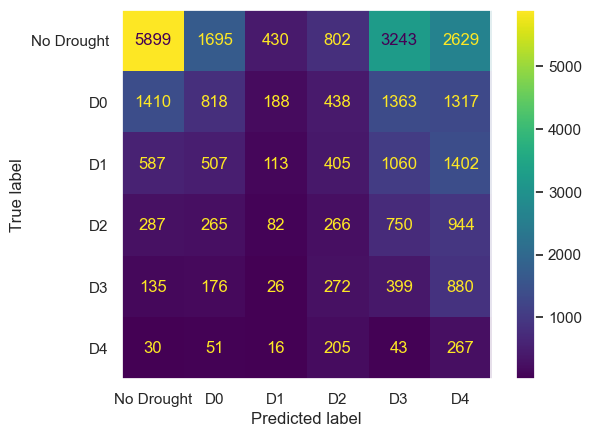

In [37]:
y_pred_clf_final= grid_model.predict(scaled_X_test)
evaluate_model_performance(y_test, y_pred_clf_final)

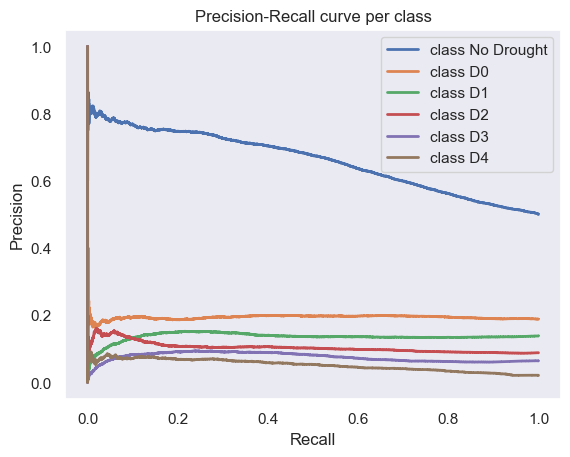

In [38]:
plot_precision_recall_curves(clf4, scaled_X_test, y_test)

***
## 15. Selection of Explanatory Variables <a id='c15'></a>
***
Finally, due to the model's limited performance on minority classes, the resulting coefficient values were displayed only for the majority class in the section below. This was specifically done by plotting  in a bar chart the coefficients of the tuned model for each variable. 

As evident from the plot, we can observe that only a small subset of variables significantly impacts the classification of the majority class. Specifically, there are only 8 out of 73 variables with coefficients exceeding an absolute value of 0.5.

In next milestone, we  aim to enhance performance for the minority classes using Random Forest Models. This will enable us to effectively distinguish between variables with significant impact and those that may be candidates for removal.

In [124]:
best_estimator = grid_model.best_estimator_
coefficients=best_estimator.coef_
coefficients.shape

(6, 73)

In [137]:
coef= pd.Series(best_estimator.coef_[0], index = X_train.columns)

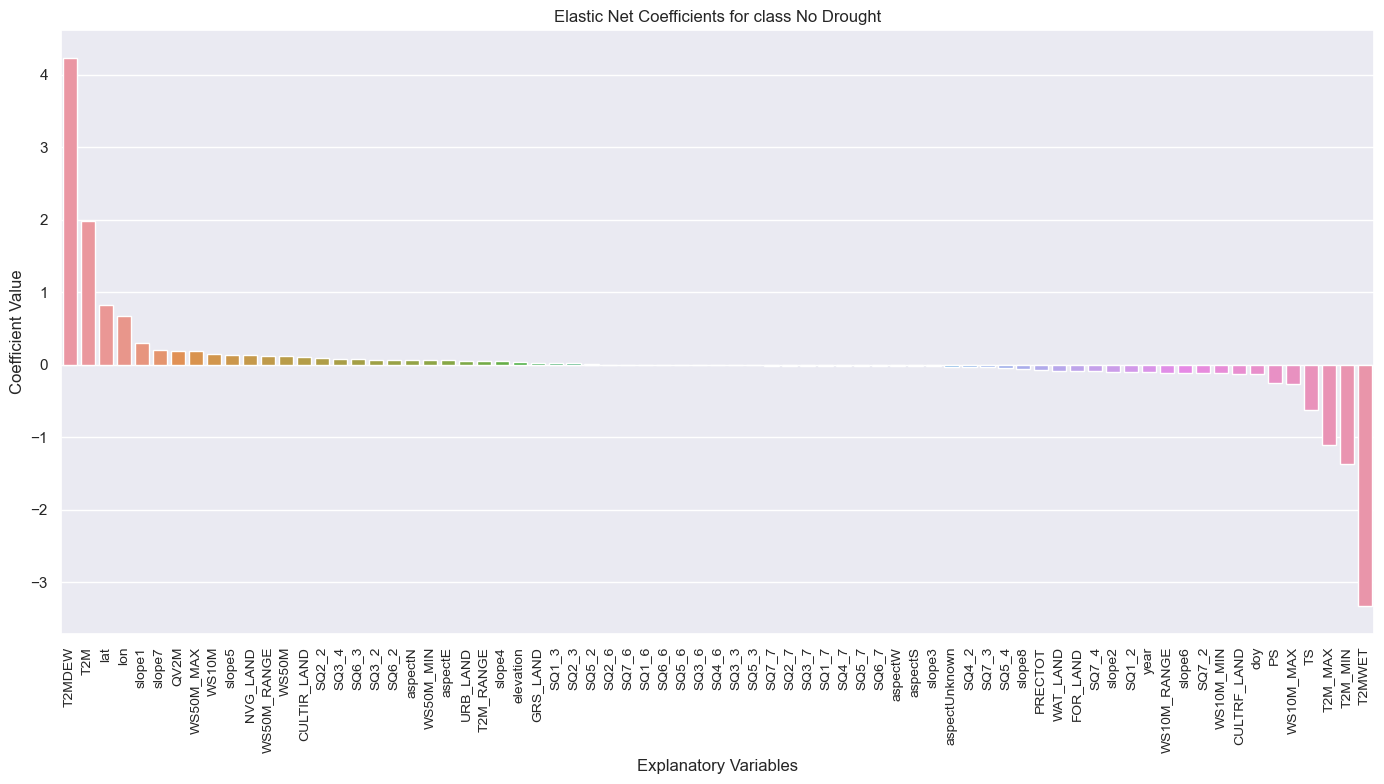

In [141]:
# Set the Seaborn style to "darkgrid"
sns.set(style="darkgrid")

# Separate coefficients into positive and negative
positive_coef = coef[coef > 0]
negative_coef = coef[coef < 0]

# Sort the positive and negative coefficients
sorted_positive_coef = positive_coef.sort_values(ascending=False)
sorted_negative_coef = negative_coef.sort_values(ascending=False)

# Concatenate positive and negative coefficients
sorted_coef = pd.concat([sorted_positive_coef, sorted_negative_coef])

# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x=sorted_coef.index, y=sorted_coef)
plt.xlabel("Explanatory Variables")
plt.ylabel("Coefficient Value")
plt.title("Elastic Net Coefficients for class No Drought")
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

***
## 16. References <a id='c16'></a>
***

* Bolinger, B (2019, August 18). How Drought Prone Is Your State? A Look at the Top States and Counties in Drought Over the Last Two Decades. Retrieved October 22, 2023, from https://www.drought.gov/news/how-drought-prone-your-state-look-top-states-and-counties-drought-over-last-two-decades
Brownlee, J. (2020a, January 17). SMOTE for Imbalanced Classification with Python. Retrieved February 17, 2023, from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
* Brownlee, J. (2020b, September 16). ROC Curves and Precision-Recall Curves for Imbalanced Classification. Retrieved October 8, 2023, from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
* Deep learning course from [François Fleuret (EPFL)](https://fleuret.org/francois/).
* He, H., & Ma, Y. (2013). Imbalanced Learning: Foundations, Algorithms, and Applications (1st ed.). Wiley-IEEE Press.
* Krishnakanth Naik Jarapala - Categorical Data Encoding Techniques from, https://medium.com/aiskunks/categorical-data-encoding-techniques-d6296697a40f
* Saxena, S. (2023, September 24). What are Categorical Data Encoding Methods | Binary Encoding. Retrieved October 9, 2023, from https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

Additional bibliography

* Surabh Bagchi (2021) Multinomial logistic regression for beginners from https://www.kaggle.com/code/saurabhbagchi/multinomial-logistic-regression-for-beginners
* Ashraf Khan (2020) Imablanced classification: cost sensitive algorithms from https://www.kaggle.com/code/ashrafkhan94/imbalanced-classification-cost-sensitive-algrthms
* Dinesh Yadav (April 2020) Weighted logistic regression for imbalanced dataset from https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
* Yuzhe Yang (May 2021) Strategies and Tactics for Regression on imbalanced dataset, from https://towardsdatascience.com/strategies-and-tactics-for-regression-on-imbalanced-data-61eeb0921fca